In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/teo/userdata/git_libraries/Yeominrak


In [2]:
from pathlib import Path
import music21
from music21 import converter, stream, note as m21_note 
from typing import List, Set, Dict, Tuple
import torch

import numpy as np
from tqdm.auto import tqdm

from yeominrak_processing import AlignedScore, SamplingScore, pack_collate, ShiftedAlignedScore, TestScore
from model_zoo import QkvRollSeq2seq, get_emb_total_size
import random as random
from loss import nll_loss
from decode import MidiDecoder
import torch
from torch.utils.data import Dataset, DataLoader
from omegaconf import OmegaConf
from metric import make_dynamic_template, convert_dynamics_to_integer, convert_note_to_sampling, convert_onset_to_sustain_token
from yeominrak_processing import SamplingTokenizer


class SamplingTestScore(TestScore):
  def __init__(self, xml_path='0_edited.musicxml', valid_measure_num=[i for i in range(93, 104)], slice_measure_num=2, 
               is_valid=False, use_pitch_modification=False, pitch_modification_ratio=0, min_meas=3, max_meas=6, transpose=0, 
               feature_types=['index', 'pitch', 'duration', 'offset', 'dynamic', 'measure_idx'],
               sampling_rate=2) -> None:
    super().__init__(xml_path, valid_measure_num, slice_measure_num, is_valid, use_pitch_modification, pitch_modification_ratio, min_meas, max_meas, transpose, feature_types)
    self.sampling_rate = sampling_rate
    self.dynamic_template_list = make_dynamic_template(beat_sampling_num=self.sampling_rate)
    self.dynamic_template_list = [convert_dynamics_to_integer(d) for d in self.dynamic_template_list]
    self.tokenizer = SamplingTokenizer(self.parts)

  def get_processed_feature(self, front_part_idx, back_part_idx, idx):
    if self.is_valid:
        measure_list = idx
    else:    
        measure_list = self.slice_info[idx]

    for i, idx in enumerate(measure_list):
      if len(self.measure_features[front_part_idx][idx]) == 0:
          return torch.LongTensor([]), torch.LongTensor([]), torch.LongTensor([])

    original_source_list = [item for idx in measure_list for item in self.measure_features[front_part_idx][idx]]
    source_roll = convert_note_to_sampling(original_source_list, self.dynamic_template_list, beat_sampling_num=self.sampling_rate)

    source_roll = convert_onset_to_sustain_token(source_roll)
    enc_in = [self.tokenizer(item) for item in source_roll]
    enc_in = torch.tensor(enc_in, dtype=torch.long)

    return enc_in
  
  def __getitem__(self, idx):
    front_part_idx, back_part_idx, measure_idx = self.result_pairs[idx]
    src  = self.get_processed_feature(front_part_idx, back_part_idx, measure_idx)
    return src
     

def get_measure_shifted_output(output: torch.Tensor):
  for i, token in enumerate(output):
    if token[3] == 3: # new measure started:
      break
  # start_token = torch.LongTensor([[part_idx, 1, 1, 3, 3, 4]]) 
  output_tokens_from_second_measure = output[i:-1].clone()
  output_tokens_from_second_measure[0, 1] = 1
  output_tokens_from_second_measure[0, 2] = 1
  output_tokens_from_second_measure[:, 5] -= 1
  return output_tokens_from_second_measure



def prepare_input_for_next_part(outputs_tensor, model):
  part_idx = outputs_tensor[0,0]
  num_measures = outputs_tensor.shape[0] // len(model.dynamic_template_list[part_idx])
  dynamic_template_repeated = torch.LongTensor(model.dynamic_template_list[part_idx] * num_measures).unsqueeze(1)
  idxs = torch.arange(0, outputs_tensor.shape[0]).unsqueeze(1) + 3
  next_input = torch.cat([outputs_tensor, dynamic_template_repeated, idxs], dim=-1)

  return next_input


def recover_beat(output: torch.Tensor, recover_amount:int):
  recover_point_pitch = output[recover_amount, 1]
  if recover_point_pitch == 3: # sustain
    for i in range(recover_amount, 0, -1):
      if output[i, 1] != 3:
        break
    recover_point_pitch = output[i, 1]
  new_output = output.clone()[recover_amount:]
  new_output[0, 1] = recover_point_pitch
  return new_output


config = OmegaConf.load('yamls/sampling_roll.yaml')
config = get_emb_total_size(config)
device = 'cpu'
val_dataset = SamplingScore(is_valid= True, slice_measure_num=4, feature_types=config.model.features)
valid_loader = DataLoader(val_dataset, batch_size=4, collate_fn=pack_collate, shuffle=False)
model = QkvRollSeq2seq(val_dataset.tokenizer, config.model).to(device)
# state = torch.load('best_model.pt')
state = torch.load('outputs/2023-12-12/02-15-40/best_model.pt')
model.load_state_dict(state)
model.eval()
decoder = MidiDecoder(val_dataset.tokenizer)


In [3]:

test_set = SamplingTestScore(xml_path='chihwapyung.musicxml', is_valid=True, 
                     valid_measure_num=[i for i in range(65)], slice_measure_num=4, transpose=+3, feature_types=config.model.features)
test_set.tokenizer = val_dataset.tokenizer

In [14]:

sampling_rate = model.sampling_rate
beat_recover_amount = [5, 5, 6, 6, 6, 6, 7, 7]
beat_recover_amount = [x * sampling_rate for x in beat_recover_amount]

print("Start inference")
score = stream.Score(id='mainScore')


source_part = stream.Part()
merged_part = stream.Part() 
outputs = []
target_idx = 1
sources = []
output_measure_len = len(model.dynamic_template_list[target_idx])
for i in tqdm(range(len(test_set))):
# for i in range(50):
  sample = test_set[i]
  src, output_decoded, (attention_map, output, new_out) = model.inference(sample, target_idx)
  if i == 0:
    new_out = output[:-output_measure_len]
  outputs.append(new_out)
  if i % test_set.slice_measure_number == 0:
    sources.append(sample)
outputs.append(output[-output_measure_len:]) # last measure
sources.append(sample[-(i % test_set.slice_measure_number) * len(model.dynamic_template_list[0]):])
sources = torch.cat(sources, dim=0)
source_midi = decoder(model.converter(recover_beat(sources[:, :2], beat_recover_amount[0])))

outputs_tensor = torch.cat([torch.LongTensor(x) for x in outputs], dim=0)
final_midi = decoder(model.converter(recover_beat(outputs_tensor, beat_recover_amount[target_idx])))


Start inference


  0%|          | 0/62 [00:00<?, ?it/s]

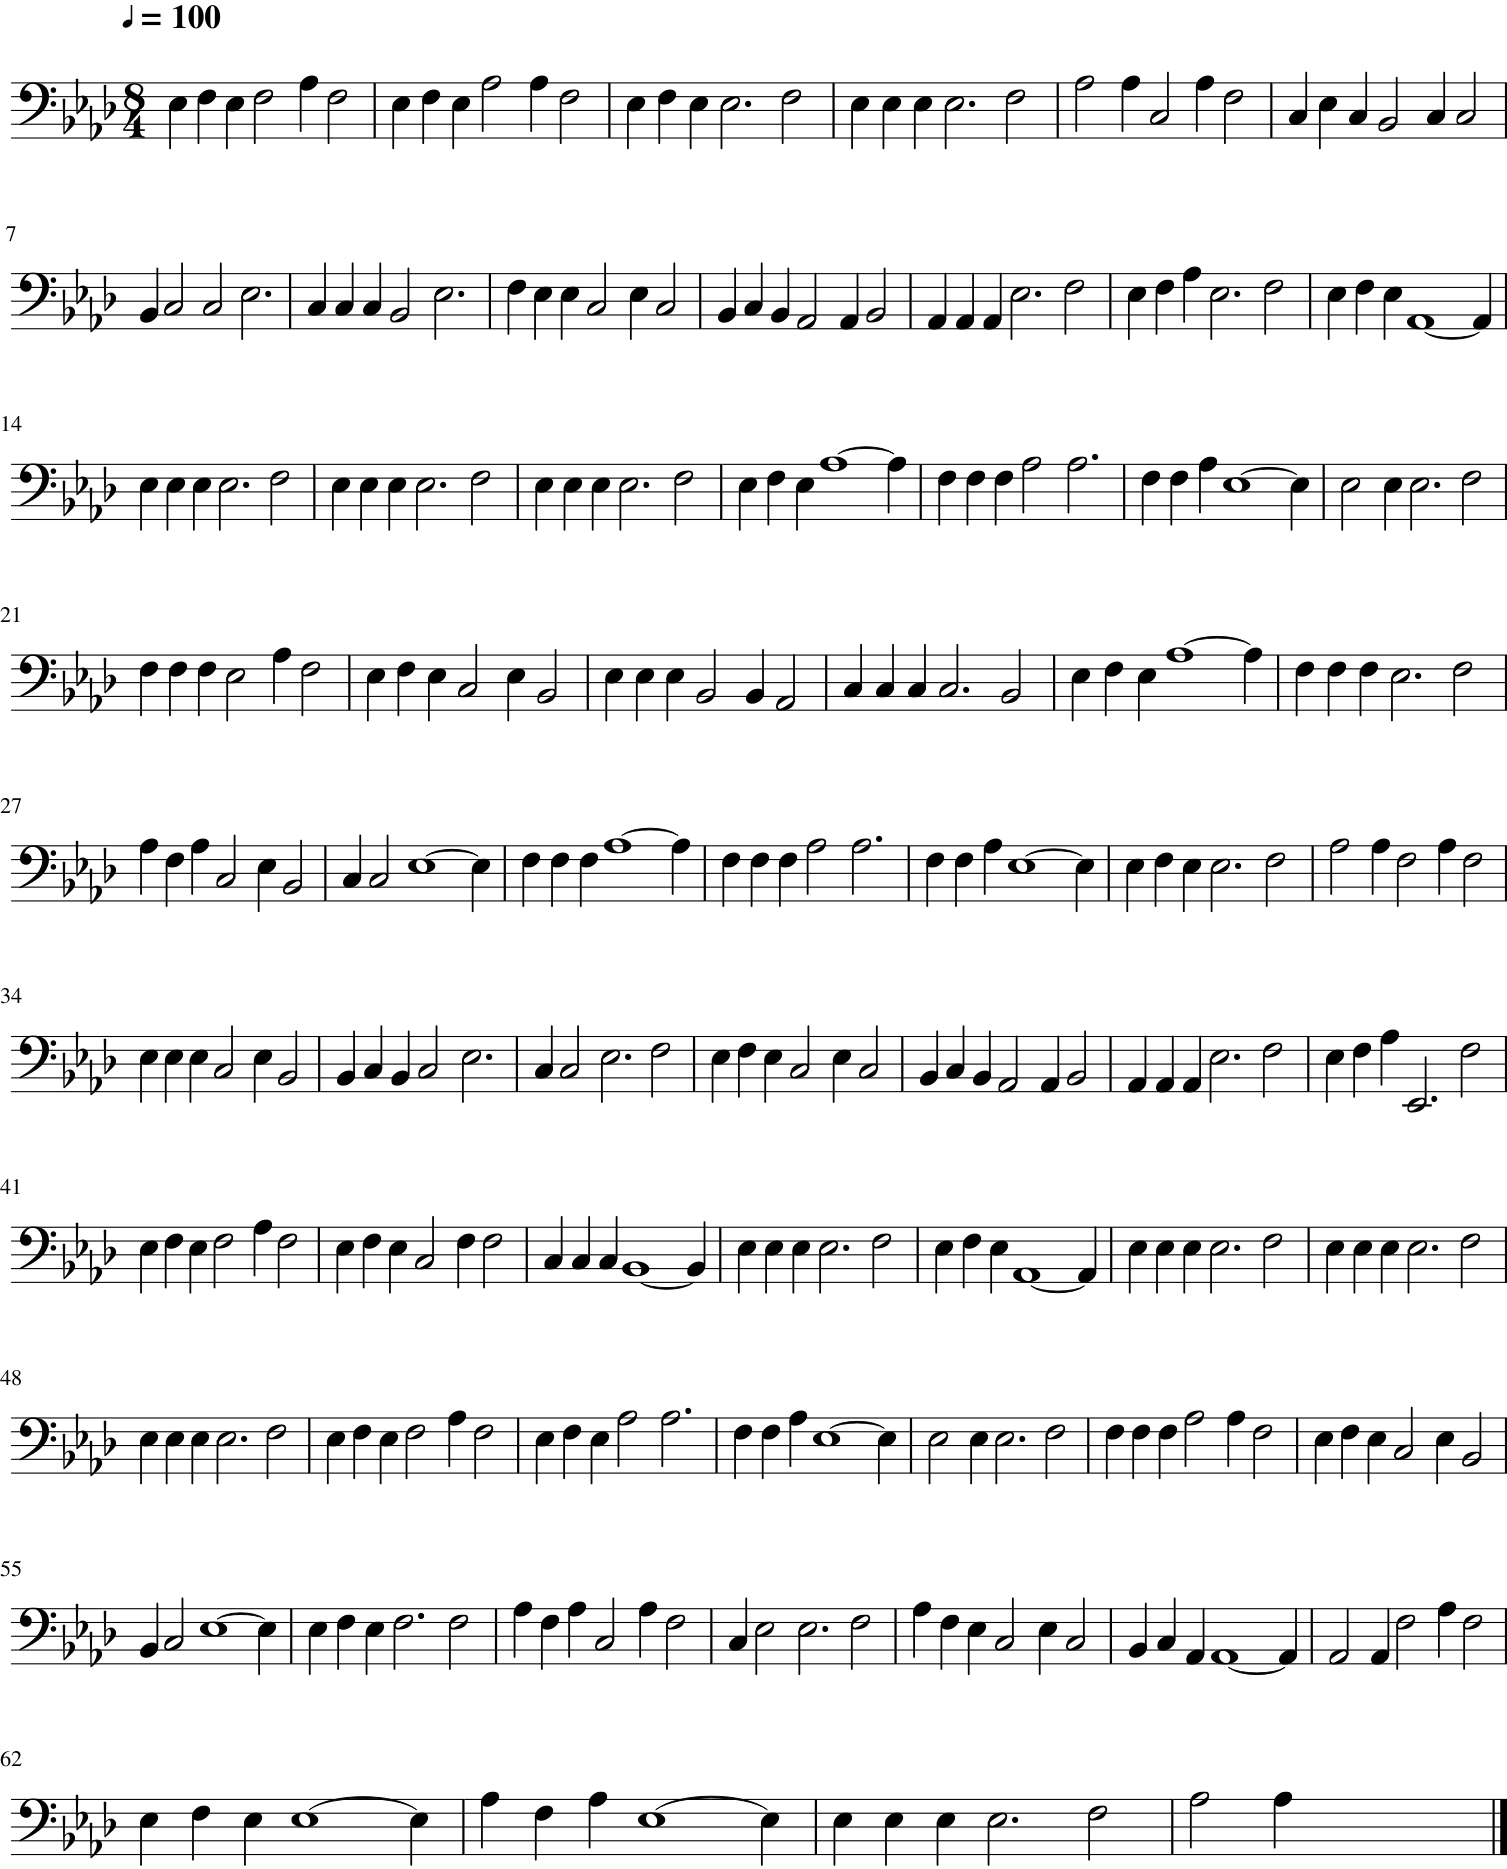

In [7]:
final_midi.show()

In [15]:

next_input = prepare_input_for_next_part(outputs_tensor, model)
num_measures = round(outputs_tensor.shape[0] / len(model.dynamic_template_list[1]))
print(outputs_tensor.shape[0] , len(model.dynamic_template_list[1]), num_measures, sources.shape)


1040 16 65 torch.Size([1040, 4])


In [40]:

output_by_part = []
for target_idx in range(2, 8):
  prev_generation = None
  outputs =[]
  measure_dur = len(model.dynamic_template_list[target_idx-1])
  output_measure_len = len(model.dynamic_template_list[target_idx])
  # for i in tqdm(range(num_measures-3)):
  for i in range(2):
    measure_start = measure_dur * i
    measure_end = measure_dur * (i+4)
    sample = next_input[measure_start:measure_end].clone()
    sample[:, -1] -= min(sample[:, -1]) - 3

    src, output_decoded, (attention_map, output, new_out) = model.inference(sample, target_idx)
    if i == 0:
      new_out = output[:-output_measure_len]
    outputs.append(new_out)

  outputs.append(output[-output_measure_len:]) # last measure
  outputs_tensor = torch.cat([torch.LongTensor(x) for x in outputs], dim=0)
  next_input = prepare_input_for_next_part(outputs_tensor, model)
  output_by_part.append(outputs_tensor)
  final_midi = decoder(model.converter(recover_beat(outputs_tensor, beat_recover_amount[target_idx])))
  merged_part = stream.Part()
  for element in final_midi:
    merged_part.append(element)
  score.insert(0, merged_part)
  break

In [38]:
len(new_out)

20

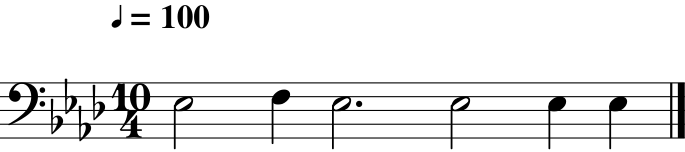

In [39]:
decoder(model.converter(new_out)).show()

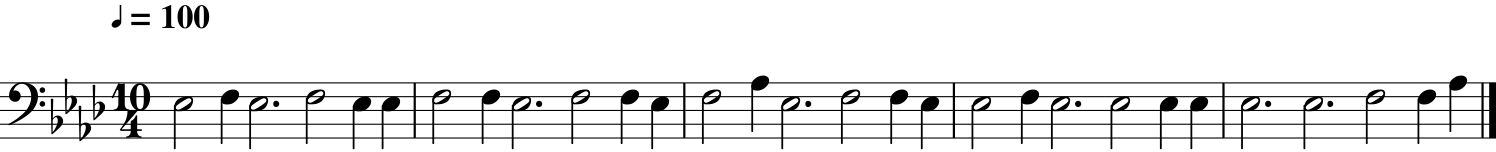

In [41]:
decoder(model.converter(outputs_tensor)).show()

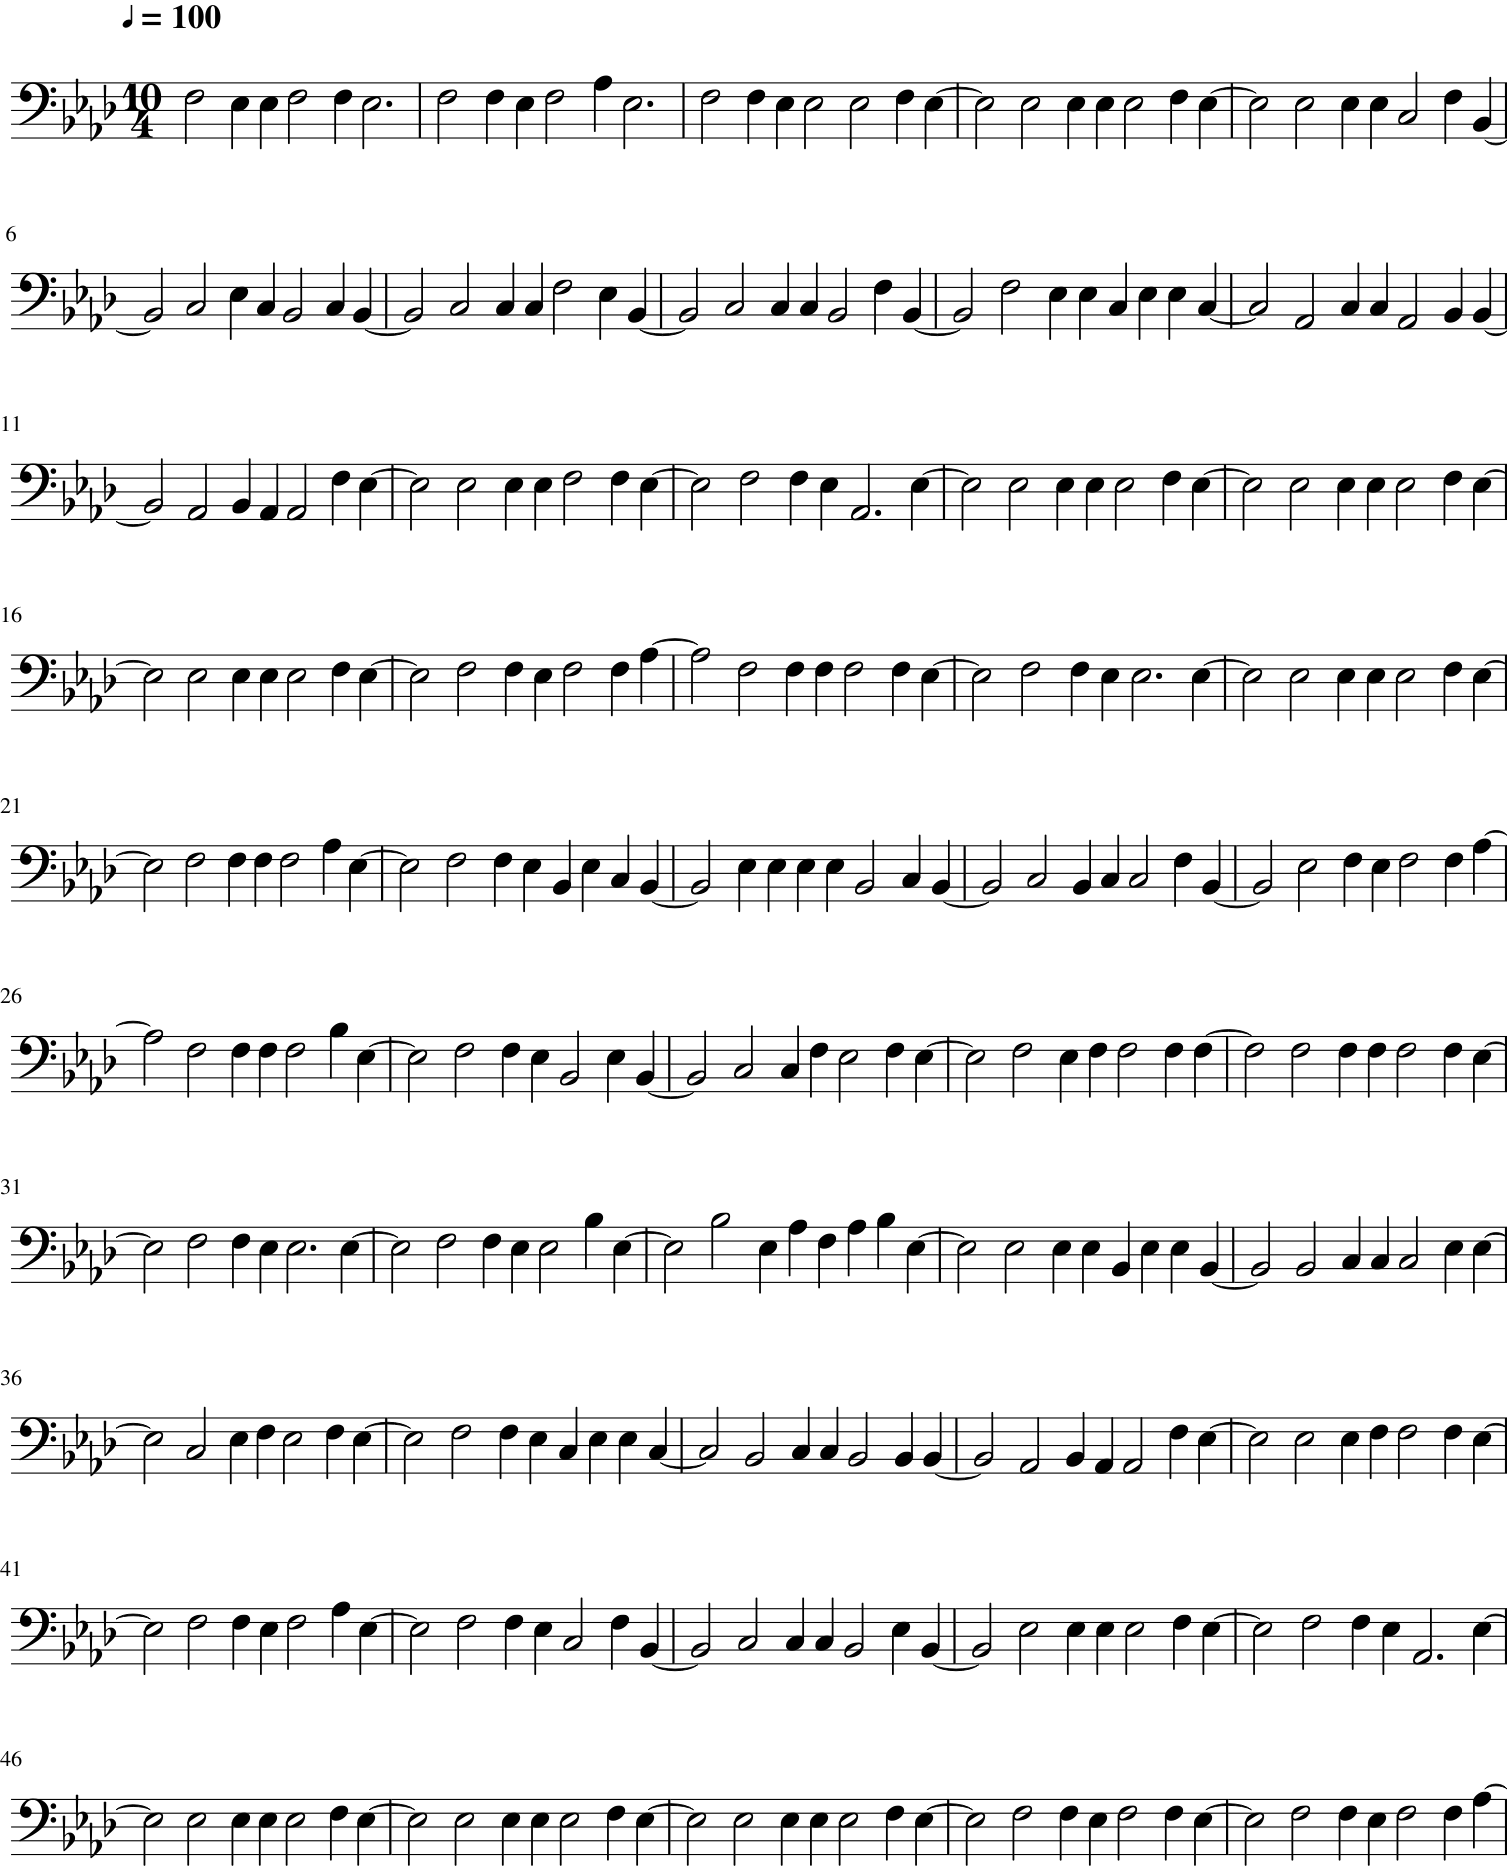

In [10]:
final_midi.show()

In [2]:
from pathlib import Path
import music21
from music21 import converter, stream, note as m21_note 
from typing import List, Set, Dict, Tuple
import torch

import numpy as np
from tqdm.auto import tqdm

from yeominrak_processing import AlignedScore, SamplingScore, pack_collate, ShiftedAlignedScore, TestScore
from model_zoo import Seq2seq, Converter, AttentionSeq2seq, QkvAttnSeq2seq, get_emb_total_size
import random as random
from loss import nll_loss
from decode import MidiDecoder
import torch
from torch.utils.data import Dataset, DataLoader
from omegaconf import OmegaConf
from fractions import Fraction




def get_measure_shifted_output(output: torch.Tensor):
  for i, token in enumerate(output):
    if token[-1] == 4: # new measure started:
      break
  for j in range(i, len(output)):
    if output[j][-1] == 6:
      break

  # return output[i:j].clone()
  # start_token = torch.LongTensor([[part_idx, 1, 1, 3, 3, 4]]) 
  # output_tokens_from_second_measure = output[i:-1].clone()
  output_tokens_from_second_measure = output[i:j].clone()
  output_tokens_from_second_measure[0, 1] = 1
  output_tokens_from_second_measure[0, 2] = 1
  output_tokens_from_second_measure[:, 5] -= 1
  return output_tokens_from_second_measure


def prepare_input_for_next_part(outputs_tensor):
  pred, condition = outputs_tensor[:, :3], outputs_tensor[:, 3:]
  next_input = torch.cat([torch.cat([pred[0:1], torch.tensor([[3,3,3]])], dim=1) , torch.cat([pred[1:], condition[:-1]], dim=1) ], dim=0)
  return next_input



config = OmegaConf.load('yamls/baseline.yaml')
config = get_emb_total_size(config)
device = 'cpu'
val_dataset = ShiftedAlignedScore(is_valid= True, slice_measure_num=4, feature_types=config.model.features)
valid_loader = DataLoader(val_dataset, batch_size=4, collate_fn=pack_collate, shuffle=False)
model = QkvAttnSeq2seq(val_dataset.tokenizer, config.model).to(device)
# state = torch.load('best_model.pt')
state = torch.load('outputs/2023-12-12/04-08-05/best_pitch_sim_model.pt')
model.load_state_dict(state)
decoder = MidiDecoder(val_dataset.tokenizer)


In [4]:

def get_measure_shifted_output(output: torch.Tensor):
  for i, token in enumerate(output):
    if token[-1] == 4: # new measure started:
      break
  for j in range(i, len(output)):
    if output[j][-1] == 6:
      break

  output_tokens_from_second_measure = output[i:j].clone()
  output_tokens_from_second_measure[0, 1] = 1
  output_tokens_from_second_measure[0, 2] = 1
  output_tokens_from_second_measure[:, 5] -= 1
  return output_tokens_from_second_measure


def prepare_input_for_next_part(outputs_tensor):
  pred, condition = outputs_tensor[:, :3], outputs_tensor[:, 3:]
  next_input = torch.cat([torch.cat([pred[0:1], torch.tensor([[3,3,3]])], dim=1) , torch.cat([pred[1:], condition[:-1]], dim=1) ], dim=0)
  return next_input

def get_measure_specific_output(output:torch.LongTensor, measure_idx_in_token:int):
  corresp_ids = torch.where(output[:,-1] == measure_idx_in_token)[0]+1
  return output[corresp_ids]


def fix_measure_idx(sample:torch.LongTensor):
  new_sample = sample.clone()
  current_measure = 2
  for note in new_sample:
    if note[1] in (1, 2): continue
    if note[3] == 3: # beat_start
      current_measure += 1
    note[5] = current_measure
  return new_sample

def recover_beat(output:torch.LongTensor, tokenizer, recover_amount=5):
  new_output = output.clone()
  accum_dur = 0
  for i, token in enumerate(new_output):
    accum_dur += tokenizer.vocab['duration'][token[2]]
    if accum_dur == recover_amount:
      break
    elif accum_dur > recover_amount:
      print('Exceed!')

  return new_output[i+1:]


def fill_in_source(src, num_measure):
  # src: list of token in strings
  outputs = []
  for note in src:
    if note[-1] in range(4-num_measure):
      continue
    else:
      outputs.append(note)
  return outputs

In [7]:

test_set = TestScore(xml_path='chihwapyung.musicxml', is_valid=True, 
                     valid_measure_num=[i for i in range(65)], slice_measure_num=4, transpose=+3, feature_types=config.model.features)
test_set.tokenizer = val_dataset.tokenizer

for i in range(30):
  if i % 3 == 0:
    continue
  if Fraction(i, 3) in model.tokenizer.tok2idx['offset_fraction']:
    continue
    print("yes")
  else:
    if i < 6:
      other_value = i % 3 + 6
    else:
      other_value = i % 3 + 21
    model.tokenizer.tok2idx['offset_fraction'][Fraction(i, 3)] = model.tokenizer.tok2idx['offset_fraction'][Fraction(other_value, 3)]


print("Start inference")
score = stream.Score(id='mainScore')
beat_recover_amount = [5, 5, 6, 6, 6, 6, 7, 7]


Start inference


In [28]:
model.eval()
prev_generation = None
outputs = []
source_part = stream.Part()
merged_part = stream.Part() 
srcs = []

for i in tqdm(range(len(test_set))):
  sample = test_set[i]
  src, output_decoded, (attention_map, output, new_out) = model.shifted_inference(sample, 1, prev_generation=prev_generation)
  if i % test_set.slice_measure_number == 0:
    srcs.append(src)
  if i == 0:
    sel_out = torch.cat([output[0:1]] + [get_measure_specific_output(output, i) for i in range(3,6)], dim=0)
  else:
    sel_out = get_measure_specific_output(output, 5) 
  prev_generation = get_measure_shifted_output(output)
  outputs.append(sel_out)

srcs.append(fill_in_source(src, i % test_set.slice_measure_number))
source_converted = [y for x in srcs for y in x]
source_part = decoder(source_converted[1:])
outputs.append(get_measure_specific_output(output, 6)) # add last measure
outputs_tensor = torch.cat(outputs, dim=0)
final_midi = decoder(model.converter(recover_beat(outputs_tensor, model.tokenizer, beat_recover_amount[1])))
score.insert(0, source_part)
score.insert(0, final_midi)

final_midi.write('midi', f'sequential_inference_CPH_{2}.mid')

next_input = prepare_input_for_next_part(outputs_tensor)
measure_boundary = torch.where(next_input[:, 3] == 3)[0].tolist() + [len(next_input)]
num_measures = len(measure_boundary)


start_token = torch.tensor([[outputs_tensor[0,0], 1, 1, 1, 1, 1]])
end_token = torch.tensor([[outputs_tensor[0,0], 2, 2, 2 , 2, 2]])

output_by_part = []
for target_idx in range(2, 7):
  prev_generation = None
  outputs =[]
  for i in tqdm(range(num_measures-4)):
    measure_start = measure_boundary[i]
    measure_end = measure_boundary[i+4]
    sample = next_input[measure_start:measure_end]
    sample = torch.cat([start_token, sample, end_token], dim=0)
    sample = fix_measure_idx(sample)
    src, output_decoded, (attention_map, output, new_out) = model.shifted_inference(sample, target_idx, prev_generation=prev_generation)

    if i == 0:
      sel_out = torch.cat([output[0:1]] + [get_measure_specific_output(output, i) for i in range(3,6)], dim=0)
    else:
      sel_out = get_measure_specific_output(output, 5) 
    prev_generation = get_measure_shifted_output(output)
    outputs.append(sel_out)
  outputs.append(get_measure_specific_output(output, 6)) # add last measure
  outputs_tensor = torch.cat(outputs, dim=0)
  next_input = prepare_input_for_next_part(outputs_tensor)
  measure_boundary = torch.where(next_input[:, 3] == 3)[0].tolist() + [len(next_input)]
  num_measures = len(measure_boundary)
  output_by_part.append(outputs_tensor)
  final_midi = decoder(model.converter(recover_beat(outputs_tensor, model.tokenizer, beat_recover_amount[target_idx])))
  merged_part = stream.Part()
  for element in final_midi:
    merged_part.append(element)
  score.insert(0, merged_part)

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

In [36]:
prev_generation = None
outputs =[]
target_idx = 7
for i in tqdm(range(num_measures-4)):
  measure_start = measure_boundary[i]
  measure_end = measure_boundary[i+4]
  sample = next_input[measure_start:measure_end]
  sample = torch.cat([start_token, sample, end_token], dim=0)
  sample = fix_measure_idx(sample)
  src, output_decoded, (attention_map, output, new_out) = model.shifted_inference(sample, target_idx, prev_generation=prev_generation)

  if i == 0:
    sel_out = torch.cat([output[0:1]] + [get_measure_specific_output(output, i) for i in range(3,6)], dim=0)
  else:
    sel_out = get_measure_specific_output(output, 5) 
  prev_generation = get_measure_shifted_output(output)
  outputs.append(sel_out)
outputs.append(get_measure_specific_output(output, 6)) # add last measure
outputs_tensor = torch.cat(outputs, dim=0)


  0%|          | 0/62 [00:00<?, ?it/s]

Triplet has to appear but not 0.5
0.5 tensor([[14,  5]])
1/3 tensor([[14,  4]])


In [37]:
model.converter(outputs_tensor)

[[7, 46.0, 0.5, 0.5, 'weak', 0],
 [7, 48.0, 0.5, 1.0, 'weak', 0],
 [7, 39.0, 1.0, 2.0, 'weak', 0],
 [7, 39.0, 1.0, 3.0, 'middle', 0],
 [7, 51.0, 1.0, 4.0, 'weak', 0],
 [7, 51.0, 1.0, 5.0, 'strong', 0],
 [7, 51.0, 1.0, 6.0, 'weak', 0],
 [7, 53.0, 1.0, 7.0, 'middle', 0],
 [7, 53.0, 0.5, 7.5, 'weak', 0],
 [7, 53.0, 0.5, 8.0, 'weak', 0],
 [7, 56.0, 1.0, 9.0, 'weak', 0],
 [7, 51.0, 1.0, 0.0, 'strong', 1],
 [7, 53.0, 1.0, 1.0, 'weak', 1],
 [7, 53.0, 1.0, 2.0, 'weak', 1],
 [7, 53.0, 0.5, 2.5, 'weak', 1],
 [7, 53.0, 0.5, 3.0, 'middle', 1],
 [7, 56.0, 1.0, 4.0, 'weak', 1],
 [7, 53.0, 0.5, 4.5, 'weak', 1],
 [7, 58.0, 0.5, 5.0, 'strong', 1],
 [7, 56.0, 1.0, 6.0, 'weak', 1],
 [7, 56.0, 1.0, 7.0, 'middle', 1],
 [7, 53.0, 0.5, 7.5, 'weak', 1],
 [7, 53.0, 0.5, 8.0, 'weak', 1],
 [7, 51.0, 1.0, 9.0, 'weak', 1],
 [7, 51.0, 1.0, 0.0, 'strong', 2],
 [7, 56.0, 1.0, 1.0, 'weak', 2],
 [7, 56.0, 1.0, 2.0, 'weak', 2],
 [7, 48.0, 0.5, 2.5, 'weak', 2],
 [7, 48.0, 0.5, 3.0, 'middle', 2],
 [7, 53.0, 1.0, 4.0, 'wea

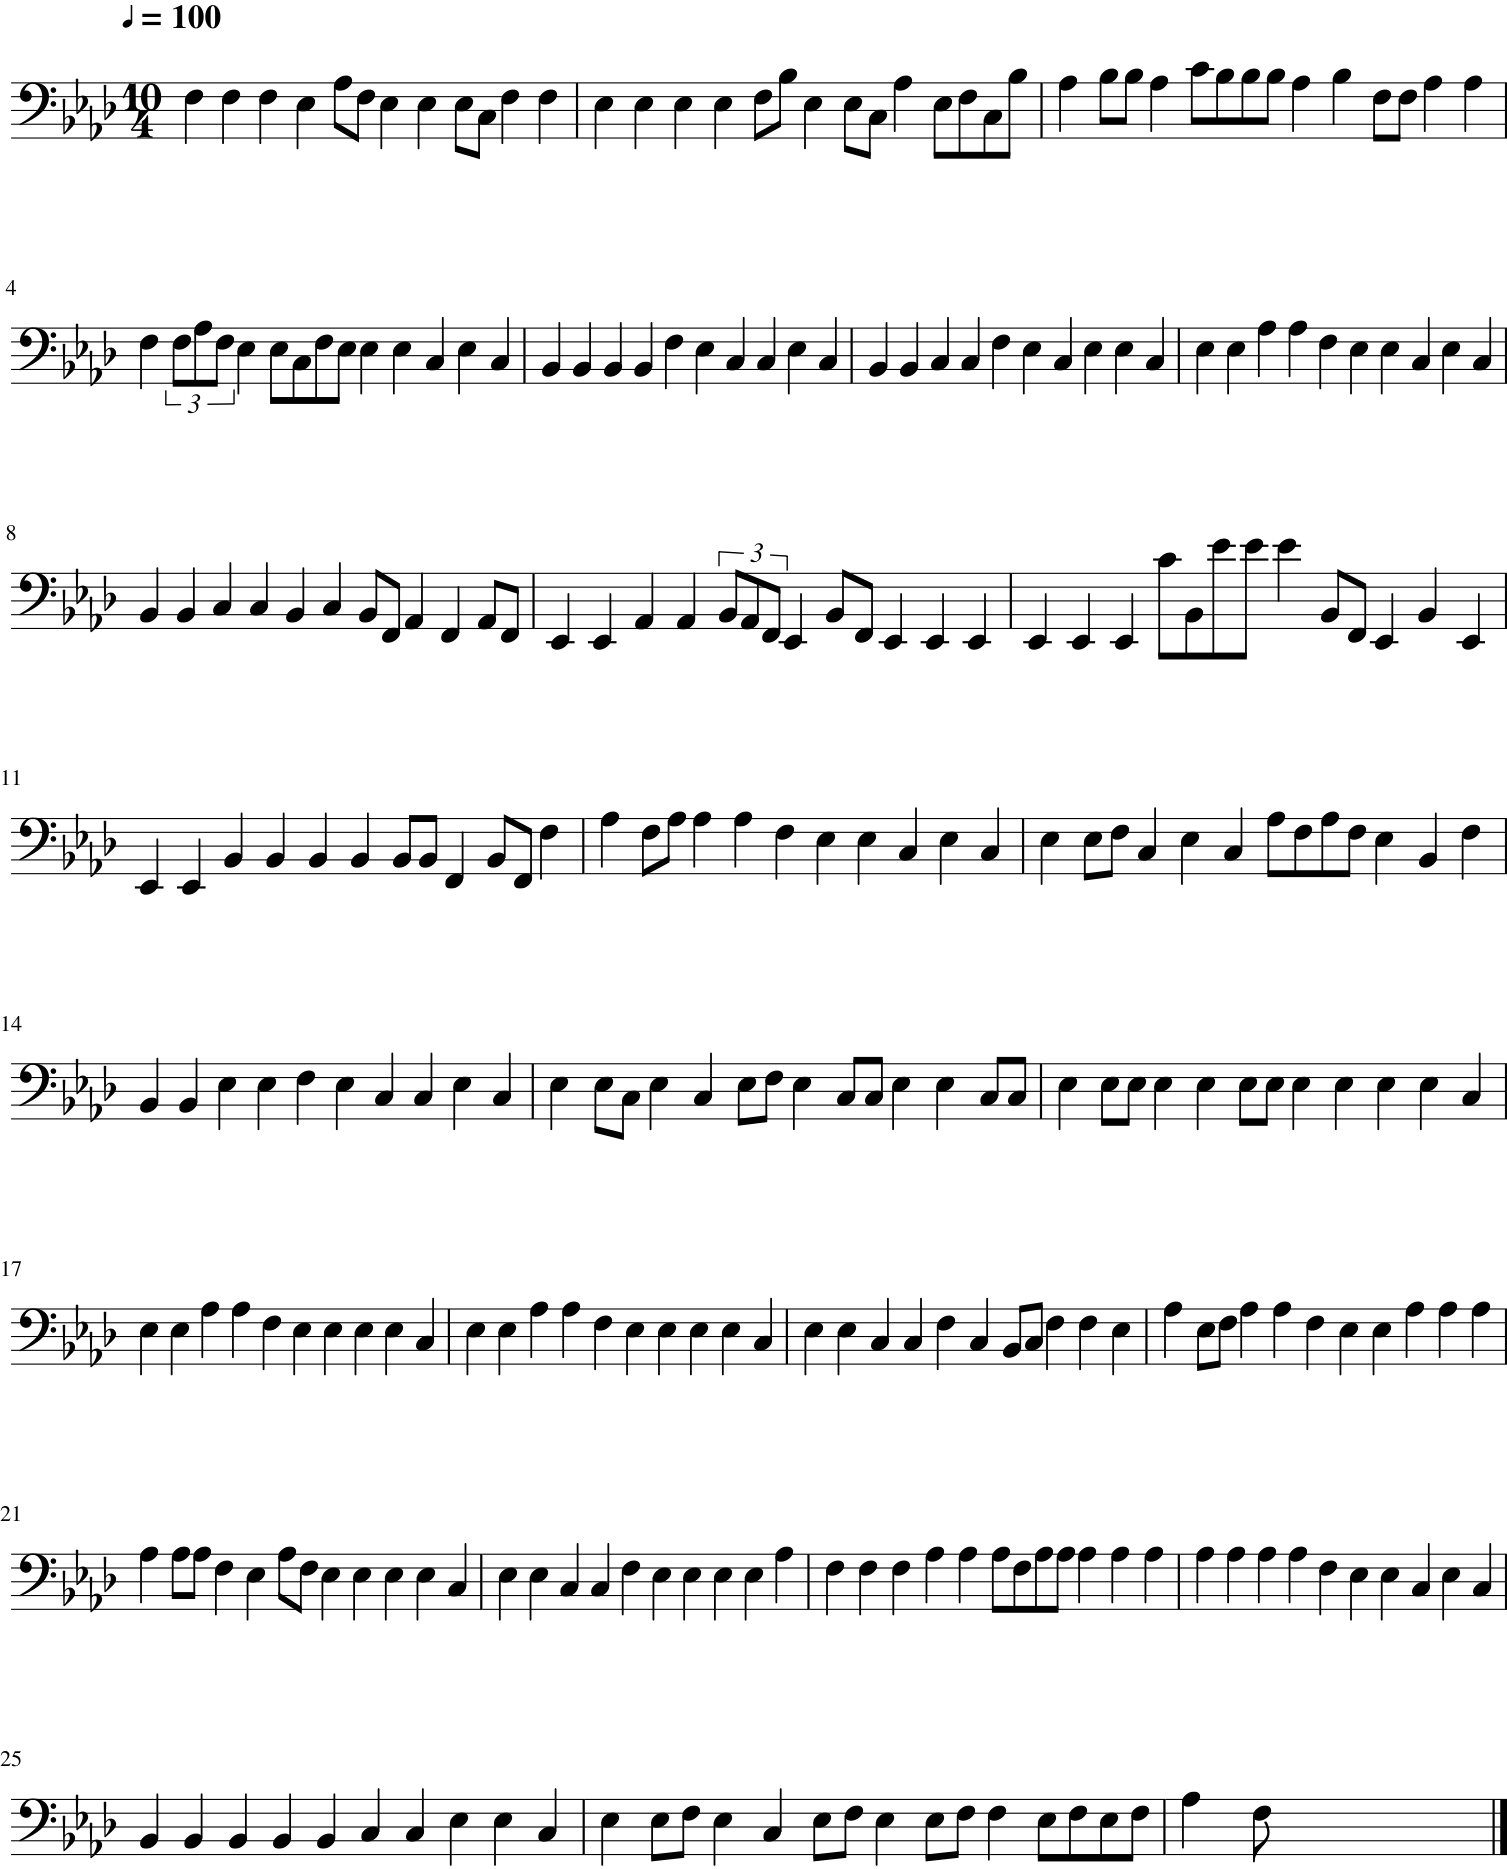

In [38]:
out = model.converter(recover_beat(output_by_part[-1], model.tokenizer, beat_recover_amount[6]))[330:-100]
decoder(out).show()

In [98]:
new_out

tensor([[ 1, 10, 10,  7,  5,  6],
        [ 1, 13,  7, 11,  4,  6],
        [ 1,  7, 10, 19,  3,  6],
        [ 1, 13,  7, 22,  5,  6],
        [ 1, 13,  7, 25,  5,  6],
        [ 1, 13,  7,  3,  3,  7]])

In [100]:
src, output_decoded, (attention_map, output, new_out) = model.shifted_inference(sample, 1, prev_generation=prev_generation)


In [102]:
output

tensor([[ 1,  8, 12, 11,  4,  3],
        [ 1, 10, 10, 19,  3,  3],
        [ 1, 10,  7, 22,  5,  3],
        [ 1, 11,  7, 25,  5,  3],
        [ 1, 11,  7,  3,  3,  4],
        [ 1, 10, 12, 11,  4,  4],
        [ 1, 10, 10, 19,  3,  4],
        [ 1, 10, 10, 25,  5,  4],
        [ 1, 10, 10,  3,  3,  5],
        [ 1, 10, 10,  7,  5,  5],
        [ 1, 13,  7, 11,  4,  5],
        [ 1,  7, 10, 19,  3,  5],
        [ 1, 13,  7, 22,  5,  5],
        [ 1, 13,  7, 25,  5,  5],
        [ 1, 13,  7,  3,  3,  6],
        [ 1, 10, 14, 19,  3,  6],
        [ 1, 13, 10, 25,  5,  6],
        [ 1, 13,  7,  3,  3,  7]])

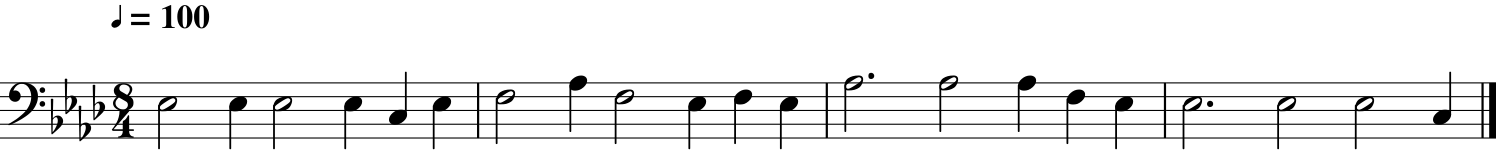

In [160]:
sample = test_set[0]
src, output_decoded, (attention_map, output, new_out) = model.shifted_inference(sample, 1, prev_generation=None)
decoder(output_decoded).show()

In [161]:
output

tensor([[ 1, 10, 10,  7,  5,  3],
        [ 1, 10,  7, 11,  4,  3],
        [ 1, 10, 10, 19,  3,  3],
        [ 1, 10,  7, 22,  5,  3],
        [ 1,  8,  7, 25,  5,  3],
        [ 1, 10,  7,  3,  3,  4],
        [ 1, 11, 10,  7,  5,  4],
        [ 1, 13,  7, 11,  4,  4],
        [ 1, 11, 10, 19,  3,  4],
        [ 1, 10,  7, 22,  5,  4],
        [ 1, 11,  7, 25,  5,  4],
        [ 1, 10,  7,  3,  3,  5],
        [ 1, 13, 12, 11,  4,  5],
        [ 1, 13, 10, 19,  3,  5],
        [ 1, 13,  7, 22,  5,  5],
        [ 1, 11,  7, 25,  5,  5],
        [ 1, 10,  7,  3,  3,  6],
        [ 1, 10, 12, 11,  4,  6],
        [ 1, 10, 10, 19,  3,  6],
        [ 1, 10, 10, 25,  5,  6],
        [ 1,  8,  7,  3,  3,  7]])

In [242]:
def get_measure_specific_output(output:torch.LongTensor, measure_idx_in_token:int):
  corresp_ids = torch.where(output[:,-1] == measure_idx_in_token)[0]+1
  return output[corresp_ids]

def fill_in_source(src, num_measure):
  # src: list of token in strings
  outputs = []
  for note in src:
    if note[-1] in range(4-num_measure):
      continue
    else:
      outputs.append(note)
  return outputs


print("Start inference")
score = stream.Score(id='mainScore')

prev_generation = None
outputs = []
source_part = stream.Part()
merged_part = stream.Part() 
srcs = []
for i in tqdm(range(len(test_set))):
  sample = test_set[i]
  src, output_decoded, (attention_map, output, new_out) = model.shifted_inference(sample, 1, prev_generation=prev_generation)
  if i % test_set.slice_measure_number == 0:
    srcs.append(src)
  if i == 0:
    sel_out = torch.cat([output[0:1]] + [get_measure_specific_output(output, i) for i in range(3,6)], dim=0)
  else:
    sel_out = get_measure_specific_output(output, 5) 
  prev_generation = get_measure_shifted_output(output)
  outputs.append(sel_out)
outputs.append(get_measure_specific_output(output, 6)) # add last measure
outputs_tensor = torch.cat(outputs, dim=0)
srcs.append(fill_in_source(src, i % test_set.slice_measure_number))
final_midi = decoder(model.converter(outputs_tensor))


Start inference


  0%|          | 0/62 [00:00<?, ?it/s]

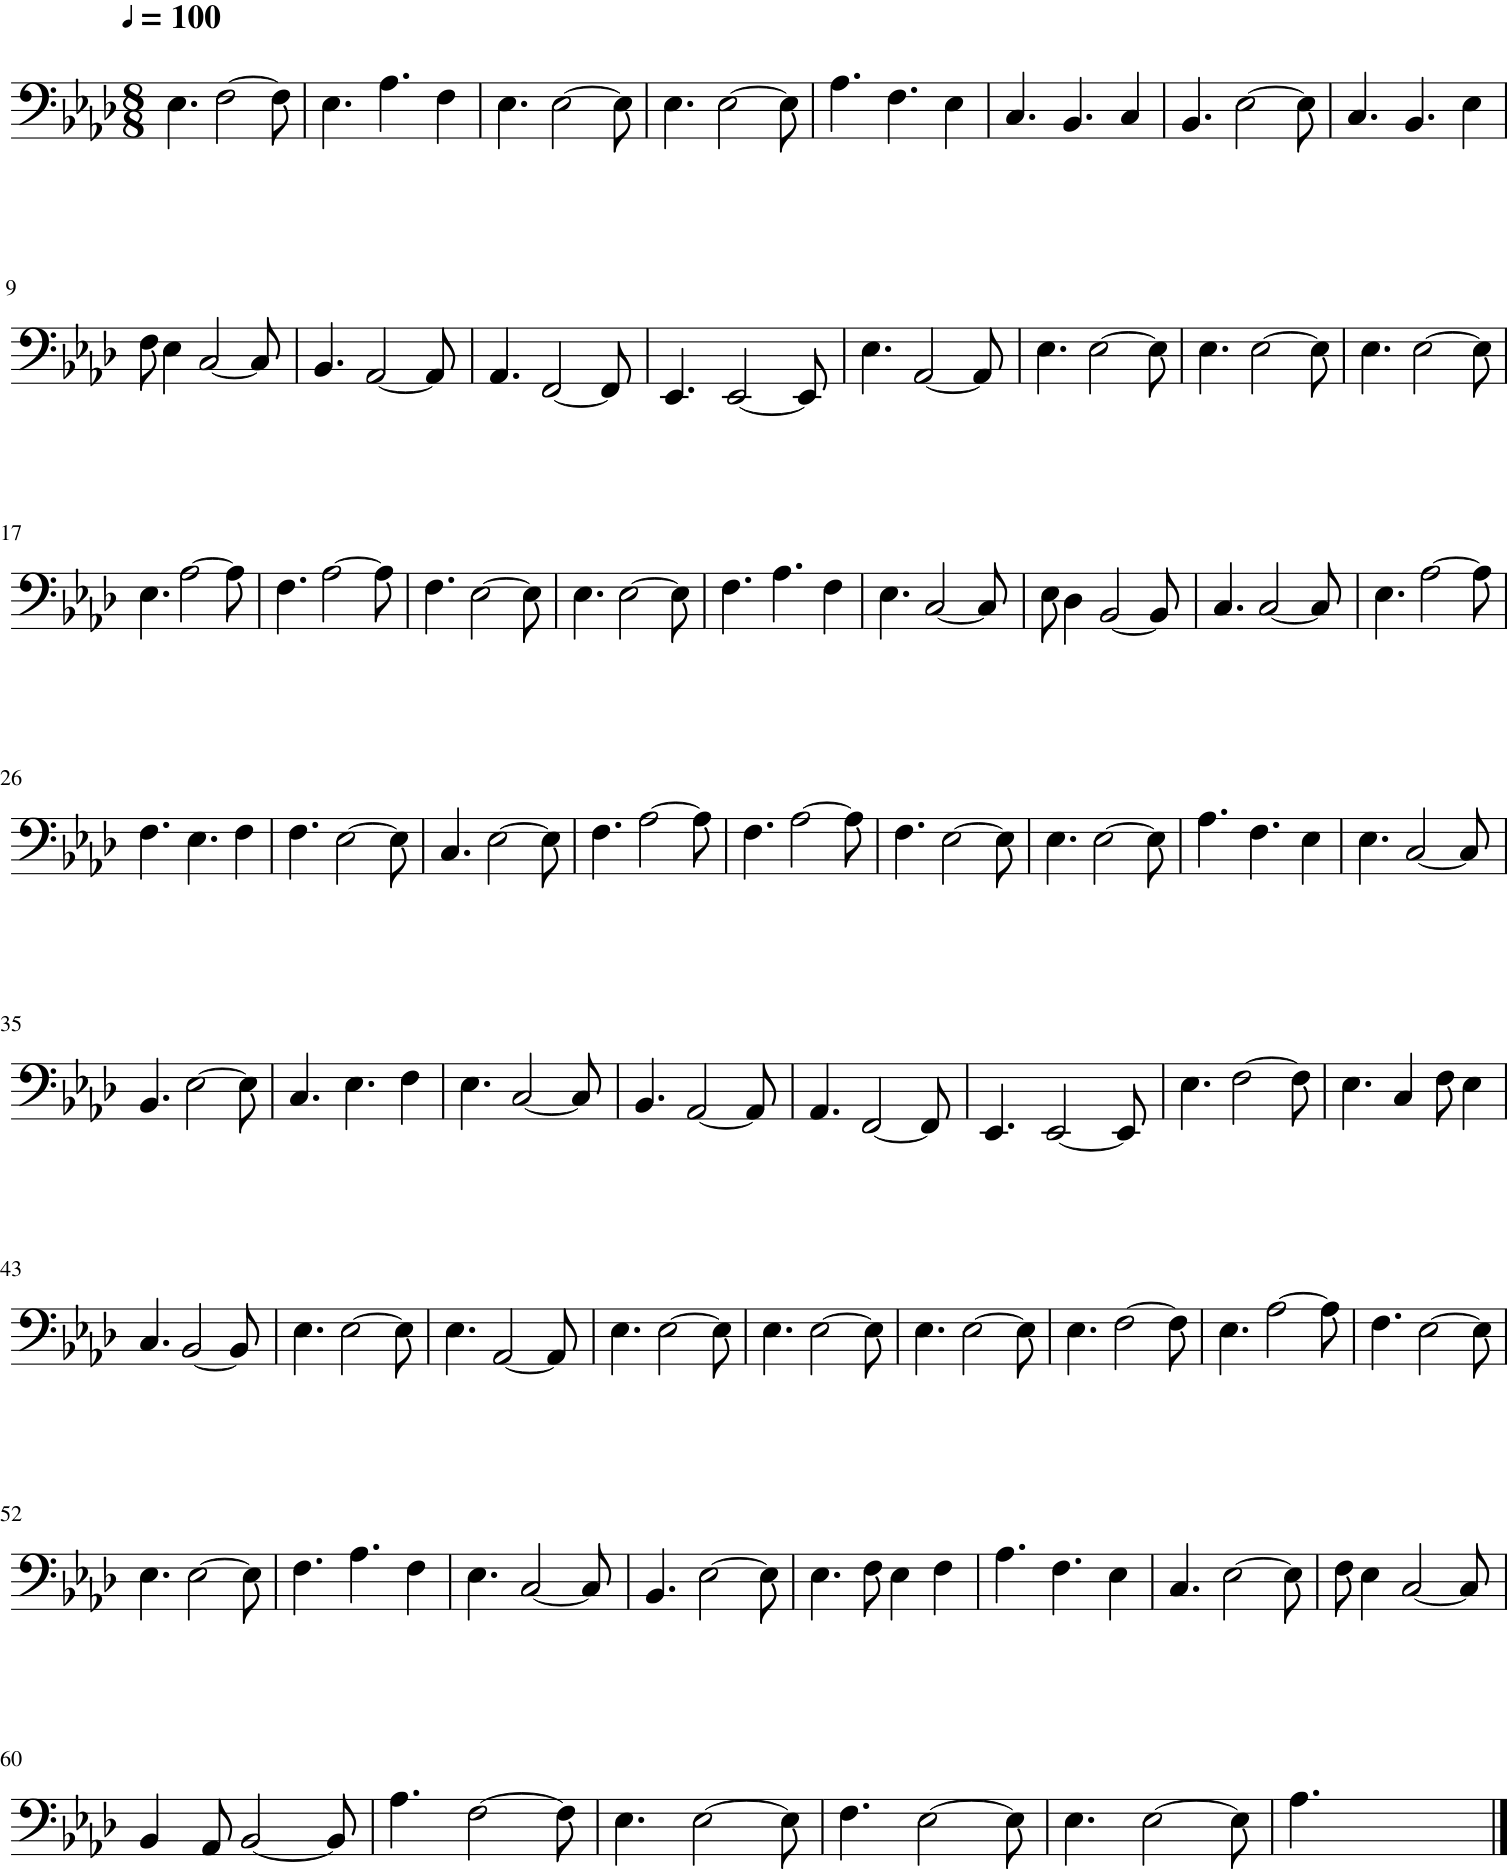

In [244]:
source_converted = [y for x in srcs for y in x]
source_part = decoder(source_converted[1:])
source_part.show()

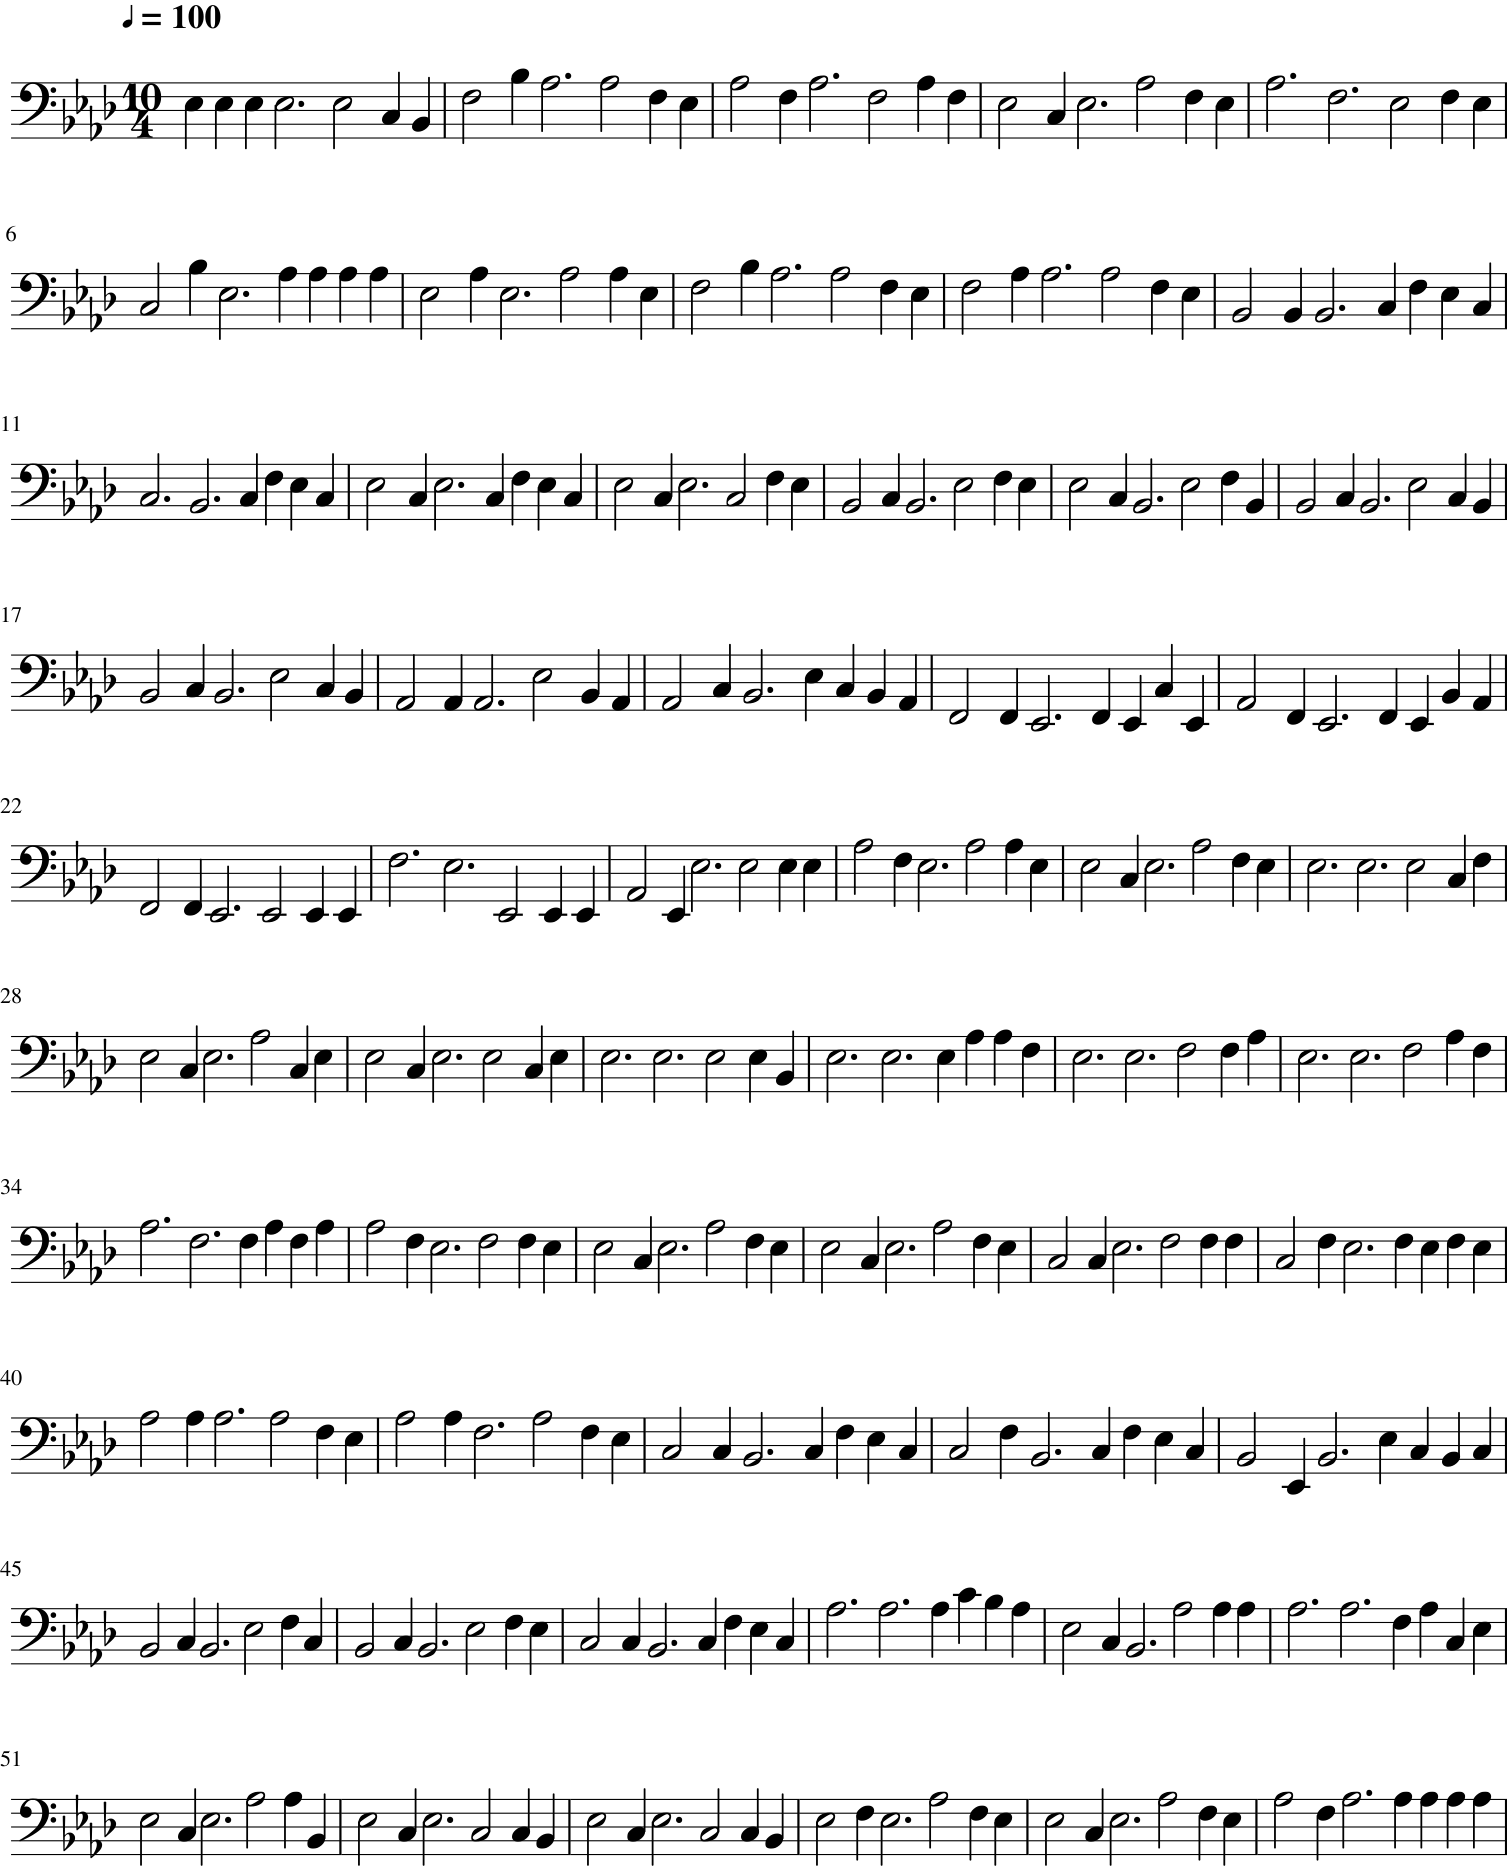

In [188]:
final_midi.show()

In [208]:
next_input = prepare_input_for_next_part(outputs_tensor)
measure_boundary = torch.where(next_input[:, 3] == 3)[0].tolist() + [len(next_input)]
num_measures = len(measure_boundary)
num_measures

66

In [209]:
def fix_measure_idx(sample:torch.LongTensor):
  new_sample = sample.clone()
  current_measure = 2
  for note in new_sample:
    if note[1] in (1, 2): continue
    if note[3] == 3: # beat_start
      current_measure += 1
    note[5] = current_measure
  return new_sample


start_token = torch.tensor([[outputs_tensor[0,0], 1, 1, 1, 1, 1]])
end_token = torch.tensor([[outputs_tensor[0,0], 2, 2, 2 , 2, 2]])



output_by_part = []
for target_idx in range(2, 8):
  prev_generation = None
  outputs =[]
  for i in tqdm(range(num_measures-4)):
    measure_start = measure_boundary[i]
    measure_end = measure_boundary[i+4]
    sample = next_input[measure_start:measure_end]
    sample = torch.cat([start_token, sample, end_token], dim=0)
    sample = fix_measure_idx(sample)
    src, output_decoded, (attention_map, output, new_out) = model.shifted_inference(sample, target_idx, prev_generation=prev_generation)

    if i == 0:
      sel_out = torch.cat([output[0:1]] + [get_measure_specific_output(output, i) for i in range(3,6)], dim=0)
    else:
      sel_out = get_measure_specific_output(output, 5) 
    prev_generation = get_measure_shifted_output(output)
    outputs.append(sel_out)
  outputs.append(get_measure_specific_output(output, 6)) # add last measure
  outputs_tensor = torch.cat(outputs, dim=0)
  next_input = prepare_input_for_next_part(outputs_tensor)
  measure_boundary = torch.where(next_input[:, 3] == 3)[0].tolist() + [len(next_input)]
  num_measures = len(measure_boundary)
  output_by_part.append(outputs_tensor)
  final_midi = decoder(model.converter(outputs_tensor))
  merged_part = stream.Part()
  for element in final_midi:
    merged_part.append(element)
  score.insert(0, merged_part)
  # final_midi.write('midi', f'sequential_inference_CPH_{target_idx}.mid')

# score.write('musicxml', 'CHP_score.musicxml')
# score.write('midi', 'CHP_score.mid')

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

In [230]:
def recover_beat(output:torch.LongTensor, tokenizer, recover_amount=5):
  new_output = output.clone()
  accum_dur = 0
  for i, token in enumerate(new_output):
    accum_dur += tokenizer.vocab['duration'][token[2]]
    if accum_dur == recover_amount:
      print(accum_dur, i)
      break
    elif accum_dur > recover_amount:
      print('Exceed!')

  return new_output[i+1:]

example = output_by_part[5]
beat_recover_amount = [5, 5, 6, 6, 6, 6, 7, 7]

recover_beat(example, model.tokenizer, recover_amount=beat_recover_amount[example[0,0]])

7.0 7


tensor([[ 7, 10,  5, 27,  5,  3],
        [ 7,  8,  5, 29,  5,  3],
        [ 7, 13,  7, 32,  5,  3],
        ...,
        [ 7, 13,  7, 29,  5,  6],
        [ 7, 13,  7, 32,  5,  6],
        [ 7, 13,  7,  3,  3,  7]])

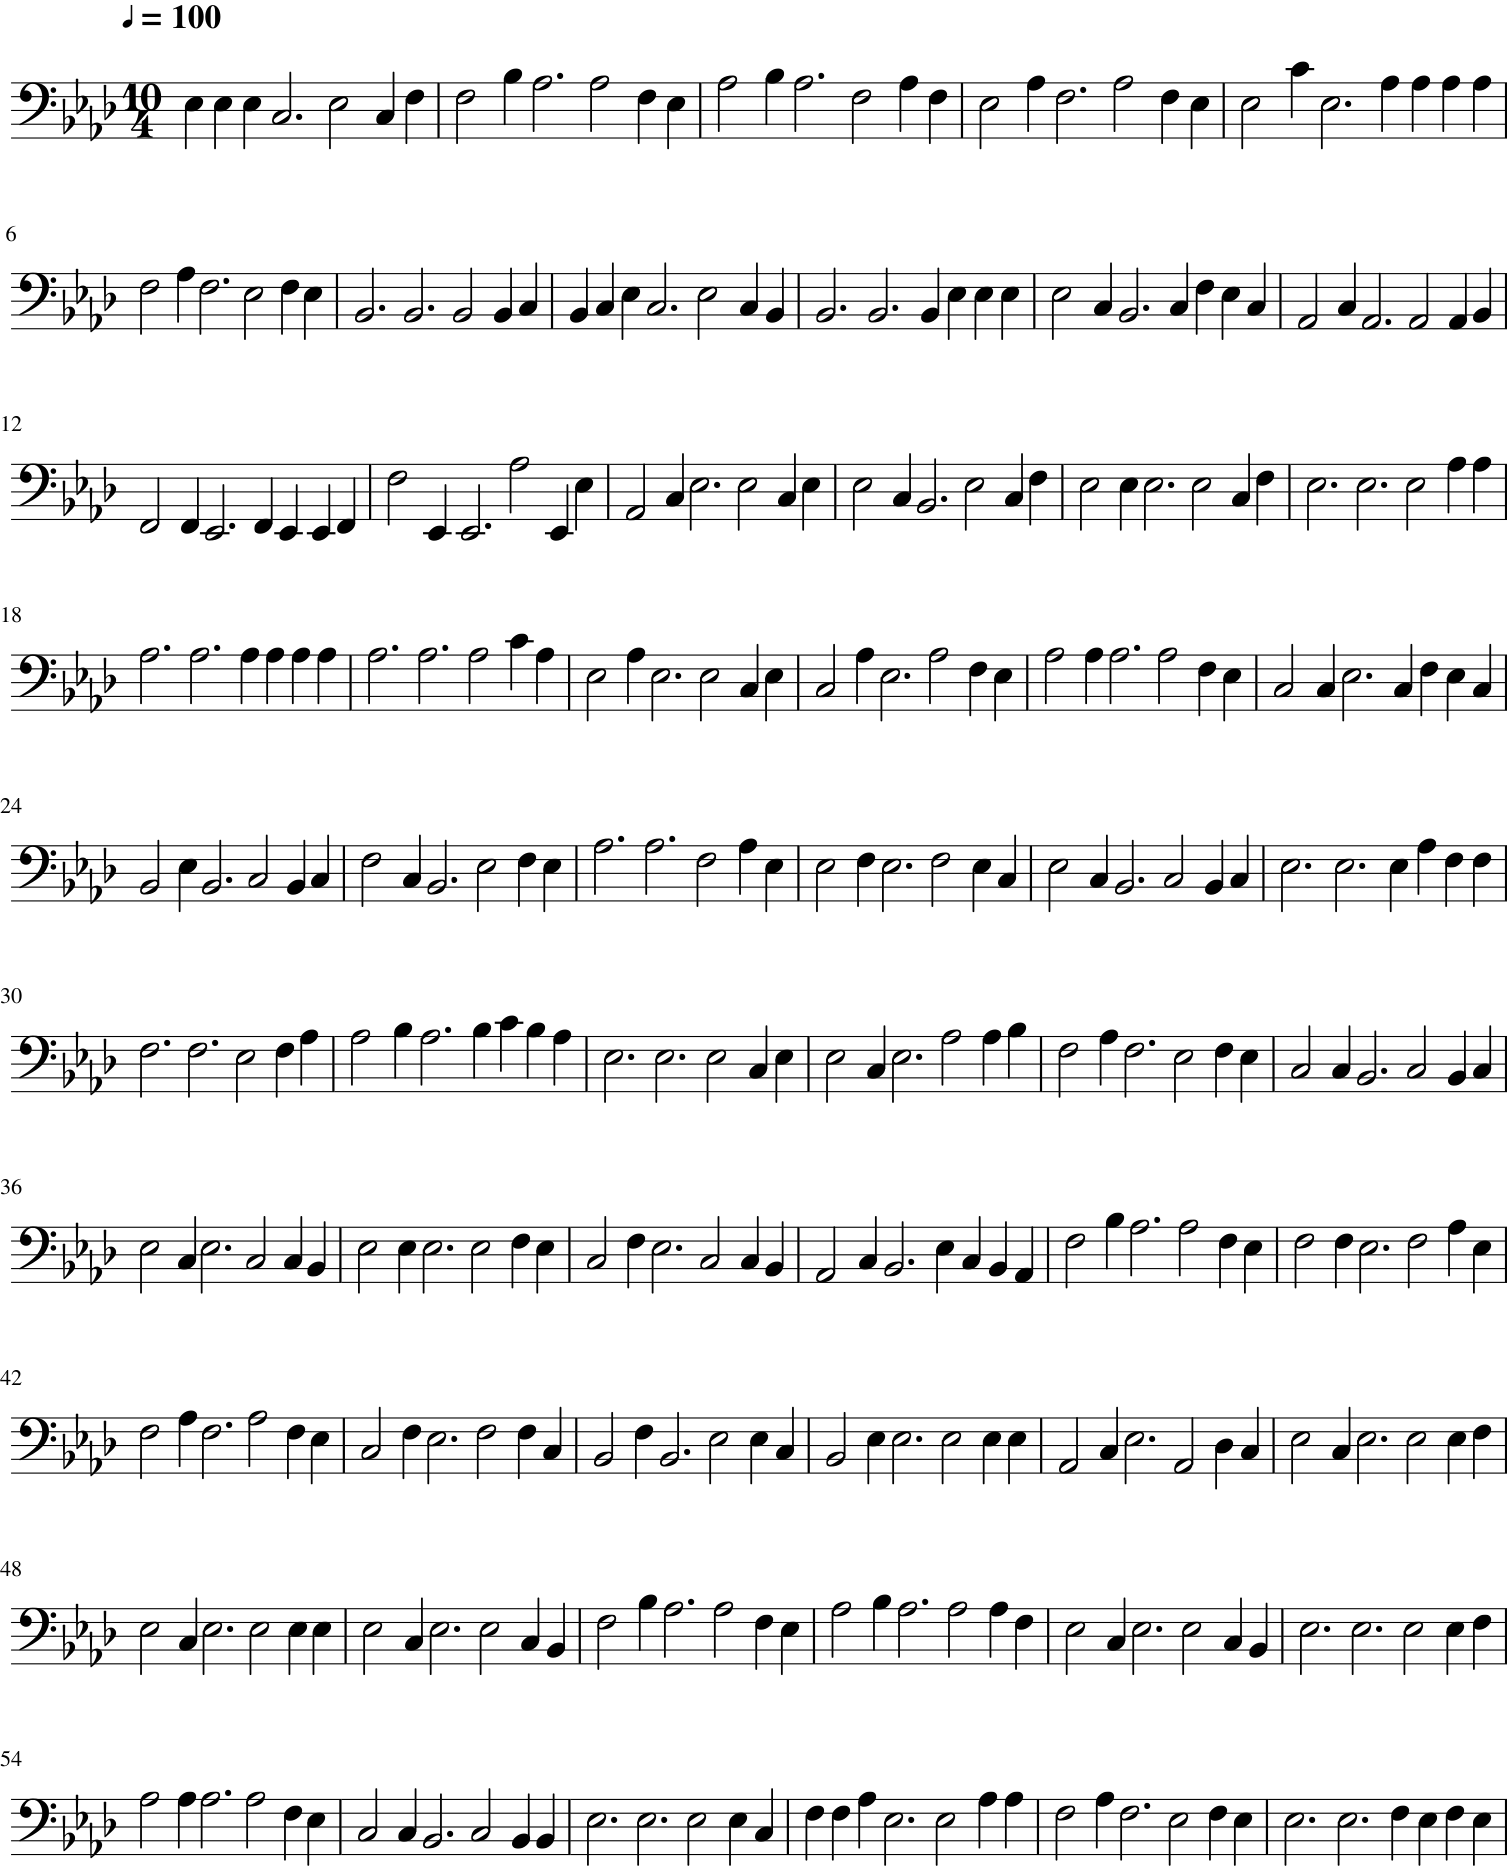

In [200]:
final_midi.show()

In [198]:
def fix_measure_idx(sample:torch.LongTensor):
  new_sample = sample.clone()
  current_measure = 2
  for note in new_sample:
    if note[1] in (1, 2): continue
    if note[3] == 3: # beat_start
      current_measure += 1
    note[5] = current_measure
  return new_sample

fix_measure_idx(sample)

tensor([[ 1,  1,  1,  1,  1,  1],
        [ 1, 10, 10,  3,  3,  3],
        [ 1, 10,  7,  7,  5,  3],
        [ 1, 10, 10, 11,  4,  3],
        [ 1, 10,  7, 19,  3,  3],
        [ 1,  8,  7, 22,  5,  3],
        [ 1, 10,  7, 25,  5,  3],
        [ 1, 11, 10,  3,  3,  4],
        [ 1, 13,  7,  7,  5,  4],
        [ 1, 11, 10, 11,  4,  4],
        [ 1, 10,  7, 19,  3,  4],
        [ 1, 11,  7, 22,  5,  4],
        [ 1, 10,  7, 25,  5,  4],
        [ 1, 13, 12,  3,  3,  5],
        [ 1, 11, 10, 11,  4,  5],
        [ 1, 13, 10, 19,  3,  5],
        [ 1, 11,  7, 25,  5,  5],
        [ 1, 10, 10,  3,  3,  6],
        [ 1, 13,  7,  7,  5,  6],
        [ 1, 11, 10, 11,  4,  6],
        [ 1, 10,  7, 19,  3,  6],
        [ 1, 11,  7, 22,  5,  6],
        [ 1, 10,  7, 25,  5,  6],
        [ 1,  2,  2,  2,  2,  2]])

In [63]:
from pathlib import Path
import music21
from music21 import converter, stream, note as m21_note 
from typing import List, Set, Dict, Tuple
import torch

import numpy as np
from tqdm.auto import tqdm

from yeominrak_processing import AlignedScore, SamplingScore, pack_collate, ShiftedAlignedScore, TestScore
from model_zoo import QkvRollSeq2seq, get_emb_total_size
import random as random
from loss import nll_loss
from decode import MidiDecoder
import torch
from torch.utils.data import Dataset, DataLoader
from omegaconf import OmegaConf
from metric import make_dynamic_template, convert_dynamics_to_integer, convert_note_to_sampling, convert_onset_to_sustain_token
from yeominrak_processing import SamplingTokenizer



def get_measure_shifted_output(output: torch.Tensor):
  for i, token in enumerate(output):
    if token[3] == 3: # new measure started:
      break
  # start_token = torch.LongTensor([[part_idx, 1, 1, 3, 3, 4]]) 
  output_tokens_from_second_measure = output[i:-1].clone()
  output_tokens_from_second_measure[0, 1] = 1
  output_tokens_from_second_measure[0, 2] = 1
  output_tokens_from_second_measure[:, 5] -= 1
  return output_tokens_from_second_measure



def prepare_input_for_next_part(outputs_tensor, model):
  part_idx = outputs_tensor[0,0]
  num_measures = outputs_tensor.shape[0] // len(model.dynamic_template_list[part_idx])
  dynamic_template_repeated = torch.LongTensor(model.dynamic_template_list[part_idx] * num_measures).unsqueeze(1)
  idxs = torch.arange(0, outputs_tensor.shape[0]).unsqueeze(1) + 3
  next_input = torch.cat([outputs_tensor, dynamic_template_repeated, idxs], dim=-1)

  return next_input


def recover_beat(output: torch.Tensor, recover_amount:int):
  recover_point_pitch = output[recover_amount, 1]
  if recover_point_pitch == 3: # sustain
    for i in range(recover_amount, 0, -1):
      if output[i, 1] != 3:
        break
    recover_point_pitch = output[i, 1]
  new_output = output.clone()[recover_amount:]
  new_output[0, 1] = recover_point_pitch
  return new_output


config = OmegaConf.load('yamls/sampling_roll.yaml')
config = get_emb_total_size(config)

device = 'cpu'
val_dataset = SamplingScore(is_valid= True, slice_measure_num=4, feature_types=config.model.features)
valid_loader = DataLoader(val_dataset, batch_size=4, collate_fn=pack_collate, shuffle=False)
model = QkvRollSeq2seq(val_dataset.tokenizer, config.model).to(device)
# state = torch.load('best_model.pt')
state = torch.load('outputs/2023-12-11/11-54-40/best_model.pt')
model.load_state_dict(state)
decoder = MidiDecoder(val_dataset.tokenizer)



sampling_rate = model.sampling_rate
beat_recover_amount = [5, 5, 6, 6, 6, 6, 7, 7]
beat_recover_amount = [x * sampling_rate for x in beat_recover_amount]

print("Start inference")

Start inference


In [62]:
test = make_dynamic_template(beat_sampling_num=2)
[convert_dynamics_to_integer(d) for d in test]
# test

[[3, 6, 5, 6, 5, 6, 4, 6, 5, 6, 3, 6, 5, 6, 5, 6],
 [3, 6, 5, 6, 5, 6, 4, 6, 5, 6, 3, 6, 5, 6, 5, 6],
 [3, 6, 5, 6, 5, 6, 4, 6, 5, 6, 5, 6, 3, 6, 5, 6, 4, 6, 5, 6],
 [3, 6, 5, 6, 5, 6, 4, 6, 5, 6, 5, 6, 3, 6, 5, 6, 4, 6, 5, 6],
 [3, 6, 5, 6, 5, 6, 4, 6, 5, 6, 5, 6, 3, 6, 5, 6, 4, 6, 5, 6],
 [3, 6, 5, 6, 5, 6, 4, 6, 5, 6, 5, 6, 3, 6, 5, 6, 4, 6, 5, 6],
 [3, 6, 5, 6, 5, 6, 4, 6, 5, 6, 3, 6, 5, 6, 4, 6, 5, 6, 5, 6],
 [3, 6, 5, 6, 5, 6, 4, 6, 5, 6, 3, 6, 5, 6, 4, 6, 5, 6, 5, 6]]

In [56]:
val_dataset.dynamic_template_list[0]

[3, 5, 5, 4, 5, 3, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6]

In [71]:
original_source_list = [item for idx in [0,1,2,3] for item in test_set.measure_features[0][idx]]
convert_onset_to_sustain_token(convert_note_to_sampling(original_source_list, test_set.dynamic_template_list, beat_sampling_num=test_set.sampling_rate))



array([[ 0, 51,  3,  0],
       [ 0,  0,  6,  1],
       [ 0,  0,  5,  2],
       [ 0,  0,  6,  3],
       [ 0,  0,  5,  4],
       [ 0,  0,  6,  5],
       [ 0,  0,  4,  6],
       [ 0,  0,  6,  7],
       [ 0,  0,  5,  8],
       [ 0,  0,  6,  9],
       [ 0, 51,  3, 10],
       [ 0,  0,  6, 11],
       [ 0,  0,  5, 12],
       [ 0,  0,  6, 13],
       [ 0,  0,  5, 14],
       [ 0,  0,  6, 15],
       [ 0, 53,  3, 16],
       [ 0,  0,  6, 17],
       [ 0,  0,  5, 18],
       [ 0,  0,  6, 19],
       [ 0,  0,  5, 20],
       [ 0,  0,  6, 21],
       [ 0,  0,  4, 22],
       [ 0,  0,  6, 23],
       [ 0,  0,  5, 24],
       [ 0,  0,  6, 25],
       [ 0, 51,  3, 26],
       [ 0,  0,  6, 27],
       [ 0,  0,  5, 28],
       [ 0,  0,  6, 29],
       [ 0,  0,  5, 30],
       [ 0,  0,  6, 31],
       [ 0, 56,  3, 32],
       [ 0,  0,  6, 33],
       [ 0,  0,  5, 34],
       [ 0,  0,  6, 35],
       [ 0,  0,  5, 36],
       [ 0,  0,  6, 37],
       [ 0, 53,  4, 38],
       [ 0,  0,  6, 39],


In [76]:
class SamplingTestScore(TestScore):
  def __init__(self, xml_path='0_edited.musicxml', valid_measure_num=[i for i in range(93, 104)], slice_measure_num=2, 
               is_valid=False, use_pitch_modification=False, pitch_modification_ratio=0, min_meas=3, max_meas=6, transpose=0, 
               feature_types=['index', 'pitch', 'duration', 'offset', 'dynamic', 'measure_idx'],
               sampling_rate=2) -> None:
    super().__init__(xml_path, valid_measure_num, slice_measure_num, is_valid, use_pitch_modification, pitch_modification_ratio, min_meas, max_meas, transpose, 
                     feature_types=feature_types)
    self.sampling_rate = sampling_rate
    self.dynamic_template_list = make_dynamic_template(beat_sampling_num=self.sampling_rate)
    self.dynamic_template_list = [convert_dynamics_to_integer(d) for d in self.dynamic_template_list]
    self.tokenizer = SamplingTokenizer(self.parts)

  def get_processed_feature(self, front_part_idx, back_part_idx, idx):
    if self.is_valid:
        measure_list = idx
    else:    
        measure_list = self.slice_info[idx]

    for i, idx in enumerate(measure_list):
      if len(self.measure_features[front_part_idx][idx]) == 0:
          return torch.LongTensor([]), torch.LongTensor([]), torch.LongTensor([])

    original_source_list = [item for idx in measure_list for item in self.measure_features[front_part_idx][idx]]
    source_roll = convert_note_to_sampling(original_source_list, self.dynamic_template_list, beat_sampling_num=self.sampling_rate)

    source_roll = convert_onset_to_sustain_token(source_roll)
    enc_in = [self.tokenizer(item) for item in source_roll]
    enc_in = torch.tensor(enc_in, dtype=torch.long)

    return enc_in
  
  def __getitem__(self, idx):
    front_part_idx, back_part_idx, measure_idx = self.result_pairs[idx]
    src  = self.get_processed_feature(front_part_idx, back_part_idx, measure_idx)
    return src
     


test_set = SamplingTestScore(xml_path='chihwapyung.musicxml', is_valid=True, 
                     valid_measure_num=[i for i in range(65)], slice_measure_num=4, transpose=+3, feature_types=config.model.features)
test_set.tokenizer = val_dataset.tokenizer


In [77]:
test_set[0]

tensor([[ 0, 11,  6,  3],
        [ 0,  3,  9,  4],
        [ 0,  3,  8,  5],
        [ 0,  3,  9,  6],
        [ 0,  3,  8,  7],
        [ 0,  3,  9,  8],
        [ 0,  3,  7,  9],
        [ 0,  3,  9, 10],
        [ 0,  3,  8, 11],
        [ 0,  3,  9, 12],
        [ 0, 11,  6, 13],
        [ 0,  3,  9, 14],
        [ 0,  3,  8, 15],
        [ 0,  3,  9, 16],
        [ 0,  3,  8, 17],
        [ 0,  3,  9, 18],
        [ 0, 12,  6, 19],
        [ 0,  3,  9, 20],
        [ 0,  3,  8, 21],
        [ 0,  3,  9, 22],
        [ 0,  3,  8, 23],
        [ 0,  3,  9, 24],
        [ 0,  3,  7, 25],
        [ 0,  3,  9, 26],
        [ 0,  3,  8, 27],
        [ 0,  3,  9, 28],
        [ 0, 11,  6, 29],
        [ 0,  3,  9, 30],
        [ 0,  3,  8, 31],
        [ 0,  3,  9, 32],
        [ 0,  3,  8, 33],
        [ 0,  3,  9, 34],
        [ 0, 14,  6, 35],
        [ 0,  3,  9, 36],
        [ 0,  3,  8, 37],
        [ 0,  3,  9, 38],
        [ 0,  3,  8, 39],
        [ 0,  3,  9, 40],
        [ 0,

In [72]:
test_set.measure_features

[[[[0, 51.0, 5.0, 0, 'strong'], [0, 51.0, 3.0, 5.0, 'strong']],
  [[0, 53.0, 5.0, 0.0, 'strong'], [0, 51.0, 3.0, 5.0, 'strong']],
  [[0, 56.0, 3.0, 0.0, 'strong'],
   [0, 53.0, 2.0, 3.0, 'middle'],
   [0, 51.0, 3.0, 5.0, 'strong']],
  [[0, 51.0, 5.0, 0.0, 'strong'], [0, 51.0, 3.0, 5.0, 'strong']],
  [[0, 51.0, 5.0, 0.0, 'strong'], [0, 56.0, 3.0, 5.0, 'strong']],
  [[0, 53.0, 3.0, 0.0, 'strong'],
   [0, 51.0, 2.0, 3.0, 'middle'],
   [0, 48.0, 3.0, 5.0, 'strong']],
  [[0, 46.0, 3.0, 0.0, 'strong'],
   [0, 48.0, 2.0, 3.0, 'middle'],
   [0, 46.0, 3.0, 5.0, 'strong']],
  [[0, 51.0, 5.0, 0.0, 'strong'], [0, 48.0, 3.0, 5.0, 'strong']],
  [[0, 46.0, 3.0, 0.0, 'strong'],
   [0, 51.0, 2.0, 3.0, 'middle'],
   [0, 53.0, 1.0, 5.0, 'strong'],
   [0, 51.0, 2.0, 6.0, 'weak']],
  [[0, 48, 5.0, 0.0, 'strong'], [0, 46.0, 3.0, 5.0, 'strong']],
  [[0, 44.0, 5.0, 0.0, 'strong'], [0, 44.0, 3.0, 5.0, 'strong']],
  [[0, 41.0, 5.0, 0.0, 'strong'], [0, 39.0, 3.0, 5.0, 'strong']],
  [[0, 39.0, 5.0, 0.0, 'strong']

In [20]:
event_dataset = ShiftedAlignedScore('0_edited.musicxml')
event_testset = TestScore('chihwapyung.musicxml', is_valid=True, valid_measure_num=[i for i in range(65)], slice_measure_num=4, transpose=+3)

In [21]:
event_testset.tokenizer = event_dataset.tokenizer

In [25]:
event_testset.measure_features[0]

[[0, 51.0, 5.0, 0, 'strong', 0], [0, 51.0, 3.0, 5.0, 'strong', 0]]

In [78]:
score = stream.Score(id='mainScore')


source_part = stream.Part()
merged_part = stream.Part() 
outputs = []
target_idx = 1
sources = []
for i in tqdm(range(len(test_set))):
# for i in range(50):
  sample = test_set[i]
  src, output_decoded, (attention_map, output, new_out) = model.inference(sample, target_idx)
  if i == 0:
    new_out = output
  outputs.append(new_out)
  if i % test_set.slice_measure_number == 0:
    sources.append(sample)
sources = torch.cat(sources, dim=0)
source_midi = decoder(model.converter(recover_beat(sources[:, :2], beat_recover_amount[0])))



  0%|          | 0/62 [00:00<?, ?it/s]

In [80]:
source_midi.notes[0].duration

<music21.duration.Duration 1.5>

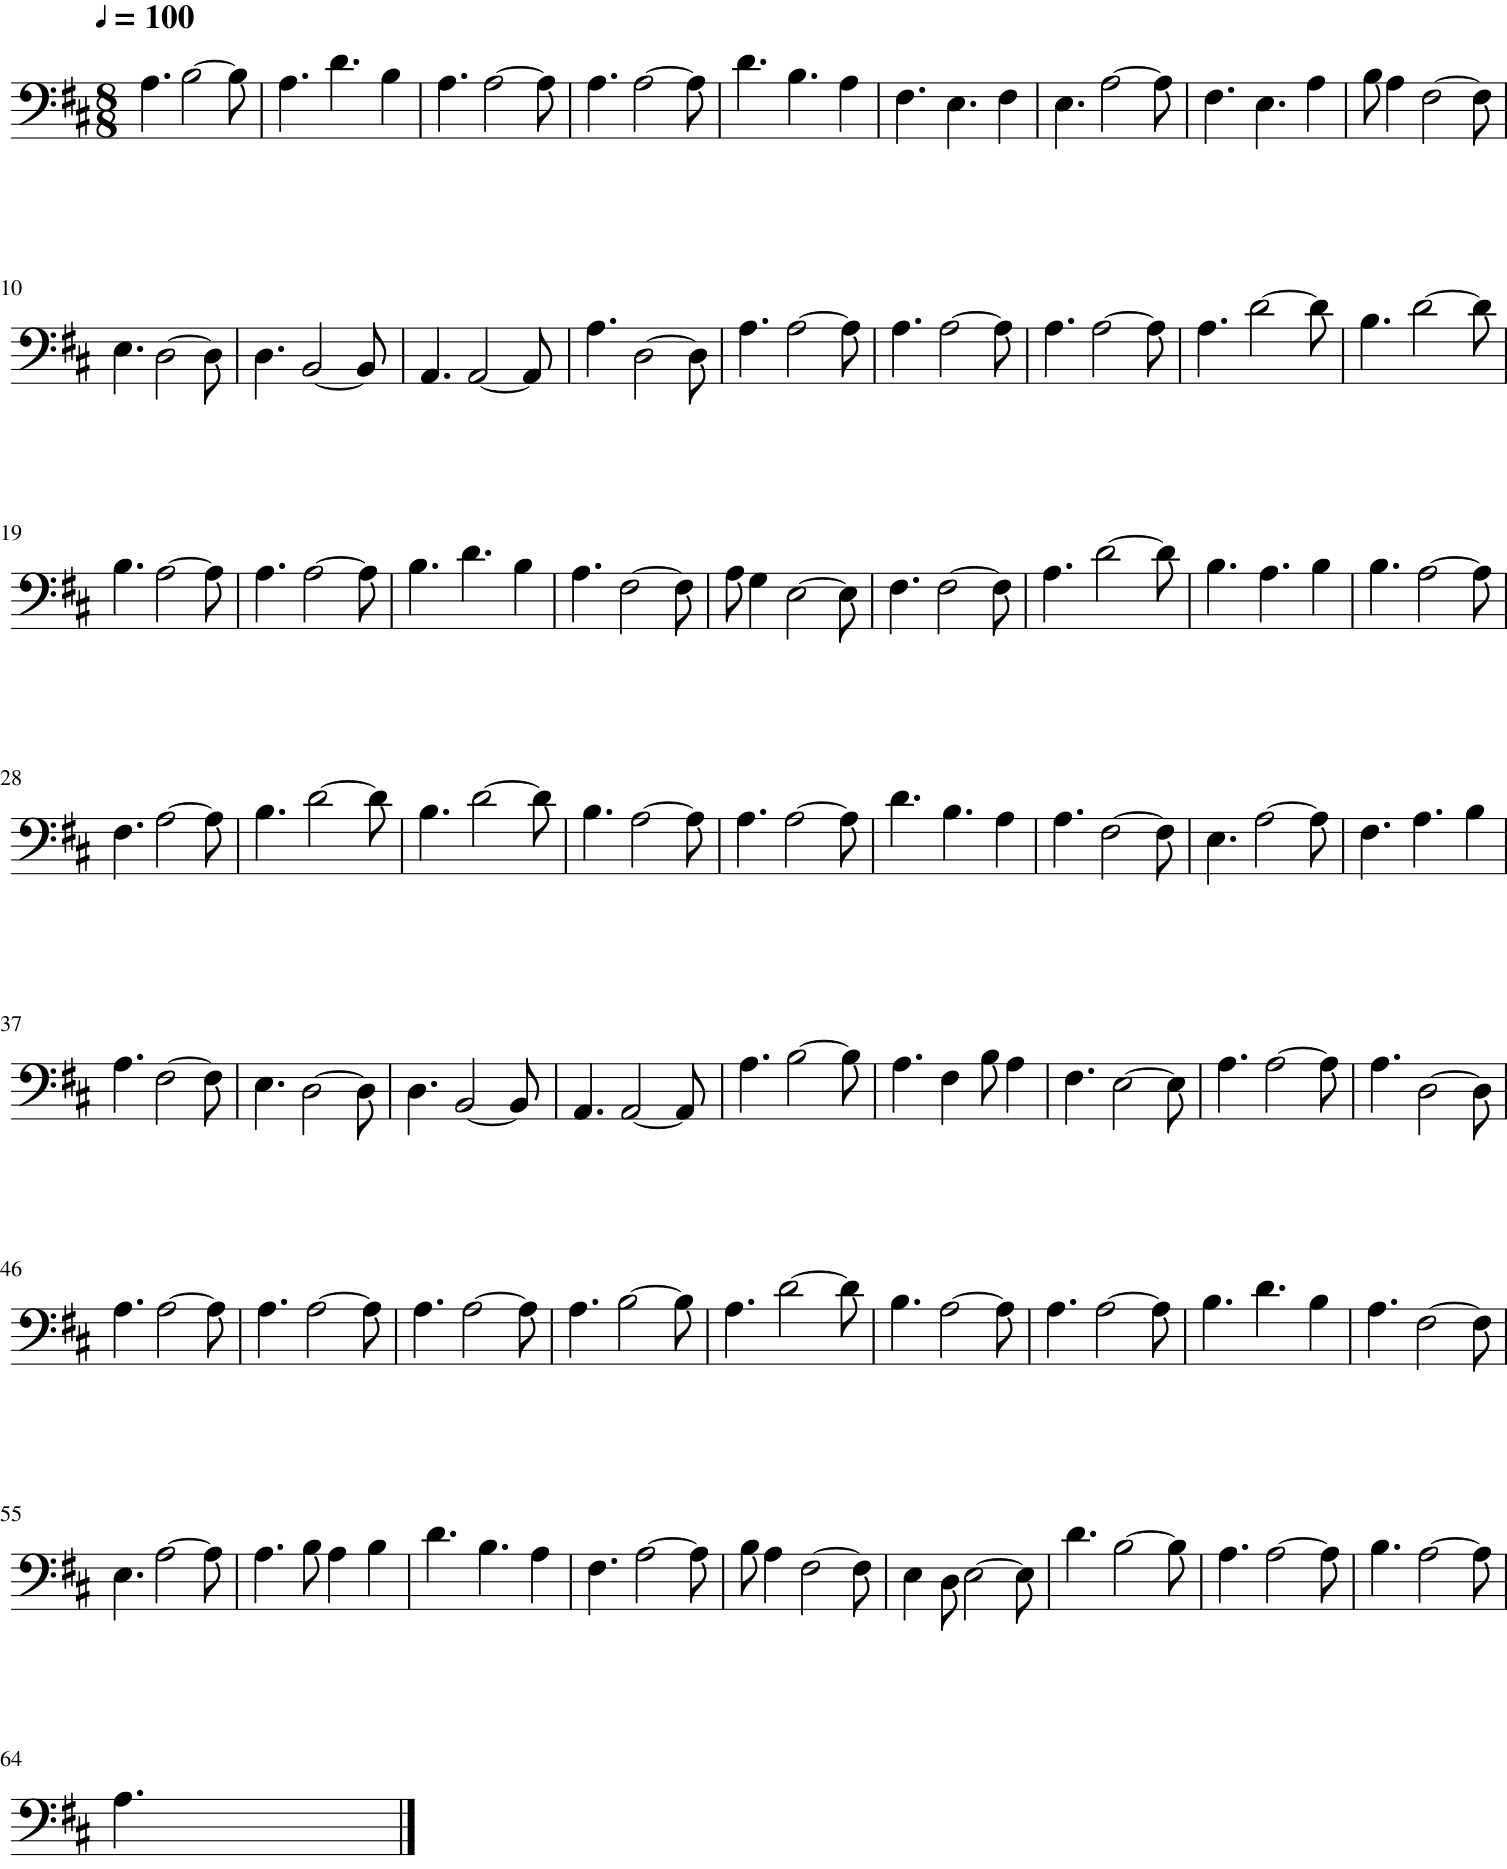

In [83]:
source_midi.transpose(+6).show()

In [43]:
print("Start inference")
score = stream.Score(id='mainScore')

prev_generation = None
outputs = []
source_part = stream.Part()
merged_part = stream.Part() 


Start inference


In [62]:
from constants import MEAS_LEN_BY_IDX

src = test_set[0]
self = model
target_idx = 1

def get_measure_shifted_output(output: torch.Tensor):
  for i, token in enumerate(output):
    if token[3] == 3: # new measure started:
      break
  # start_token = torch.LongTensor([[part_idx, 1, 1, 3, 3, 4]]) 
  output_tokens_from_second_measure = output[i:-1].clone()
  output_tokens_from_second_measure[0, 1] = 1
  output_tokens_from_second_measure[0, 2] = 1
  output_tokens_from_second_measure[:, 5] -= 1
  return output_tokens_from_second_measure

# ------

encode_out, enc_last_hidden = self.encoder(src.unsqueeze(0)) 
src_part_idx = int(src[0][0])

measure_len = int(src.shape[0] / self.sampling_rate / MEAS_LEN_BY_IDX[src_part_idx])
dec_input = self.make_dec_input(target_idx, measure_len)
dec_input = self.decoder._get_embedding(dec_input)
decode_out, last_hidden = self.decoder.rnn(dec_input.unsqueeze(0), enc_last_hidden)
attention_vectors, attention_weight = self._get_attention_vector(encode_out, decode_out)
combined_value = torch.cat([decode_out, attention_vectors], dim=-1)
combined_value = combined_value.squeeze(0)
logit = self.decoder.proj(combined_value)
selected_pitch = torch.argmax(logit, dim=-1)

selected_token = [[target_idx, int(p)] for p in selected_pitch]

returns = self.converter([note[:2] for note in src]), self.converter(selected_token), (attention_weight, selected_token, selected_token[-len(model.dynamic_template_list[1]):])

  
src, output_decoded, (attention_map, output, new_out)  = returns

In [60]:
selected_token[-len(model.dynamic_template_list[1]):]

[[1, 11],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 11],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 11],
 [1, 3],
 [1, 3],
 [1, 3],
 [1, 11],
 [1, 3]]

In [125]:
test_set[0].shape

torch.Size([64, 4])

In [126]:
sampling_rate = model.sampling_rate
beat_recover_amount = [5, 5, 6, 6, 6, 6, 7, 7]
beat_recover_amount = [x * sampling_rate for x in beat_recover_amount]
def recover_beat(output: torch.Tensor, recover_amount:int):
  recover_point_pitch = output[recover_amount, 1]
  if recover_point_pitch == 3: # sustain
    for i in range(recover_amount, 0, -1):
      if output[i, 1] != 3:
        break
    recover_point_pitch = output[i, 1]
  new_output = output.clone()[recover_amount:]
  new_output[0, 1] = recover_point_pitch
  return new_output



In [127]:
source_part = stream.Part()
merged_part = stream.Part() 
outputs = []
target_idx = 1
sources = []
for i in tqdm(range(len(test_set))):
# for i in range(50):
  sample = test_set[i]
  src, output_decoded, (attention_map, output, new_out) = model.inference(sample, target_idx)
  if i == 0:
    new_out = output
  outputs.append(new_out)
  if i % test_set.slice_measure_number == 0:
    sources.append(sample)
sources = torch.cat(sources, dim=0)

  0%|          | 0/506 [00:00<?, ?it/s]

In [137]:

recovered_source = recover_beat(sources, beat_recover_amount[0])

In [139]:
model.converter(recovered_source[:,:2])

[[0, 51.0, 3.0],
 [0, 53.0, 5.0],
 [0, 51.0, 3.0],
 [0, 56.0, 3.0],
 [0, 53.0, 2.0],
 [0, 51.0, 3.0],
 [0, 51.0, 5.0],
 [0, 51.0, 3.0],
 [0, 51.0, 5.0],
 [0, 56.0, 3.0],
 [0, 53.0, 3.0],
 [0, 51.0, 2.0],
 [0, 48.0, 3.0],
 [0, 46.0, 3.0],
 [0, 48.0, 2.0],
 [0, 46.0, 3.0],
 [0, 51.0, 5.0],
 [0, 48.0, 3.0],
 [0, 46.0, 3.0],
 [0, 51.0, 2.0],
 [0, 53.0, 1.0],
 [0, 51.0, 2.0],
 [0, 48.0, 5.0],
 [0, 46.0, 3.0],
 [0, 44.0, 5.0],
 [0, 44.0, 3.0],
 [0, 41.0, 5.0],
 [0, 39.0, 3.0],
 [0, 39.0, 5.0],
 [0, 51.0, 3.0],
 [0, 44.0, 5.0],
 [0, 51.0, 3.0],
 [0, 51.0, 5.0],
 [0, 51.0, 3.0],
 [0, 51.0, 5.0],
 [0, 51.0, 3.0],
 [0, 51.0, 5.0],
 [0, 51.0, 3.0],
 [0, 56.0, 5.0],
 [0, 53.0, 3.0],
 [0, 56.0, 5.0],
 [0, 53.0, 3.0],
 [0, 51.0, 5.0],
 [0, 51.0, 3.0],
 [0, 51.0, 5.0],
 [0, 53.0, 3.0],
 [0, 56.0, 3.0],
 [0, 53.0, 2.0],
 [0, 51.0, 3.0],
 [0, 48.0, 5.0],
 [0, 51.0, 1.0],
 [0, 49.0, 2.0],
 [0, 46.0, 5.0],
 [0, 48.0, 3.0],
 [0, 48.0, 5.0],
 [0, 51.0, 3.0],
 [0, 56.0, 5.0],
 [0, 53.0, 3.0],
 [0, 51.0, 3.0

In [111]:
outputs_tensor = torch.cat([torch.LongTensor(x) for x in outputs], dim=0)
final_midi = decoder(model.converter(outputs_tensor))


In [112]:
def prepare_input_for_next_part(outputs_tensor, model):
  part_idx = outputs_tensor[0,0]
  num_measures = outputs_tensor.shape[0] // len(model.dynamic_template_list[part_idx])
  dynamic_template_repeated = torch.LongTensor(model.dynamic_template_list[part_idx] * num_measures).unsqueeze(1)
  idxs = torch.arange(0, outputs_tensor.shape[0]).unsqueeze(1) + 3
  next_input = torch.cat([outputs_tensor, dynamic_template_repeated, idxs], dim=-1)

  return next_input

next_input = prepare_input_for_next_part(outputs_tensor, model)
next_input

tensor([[   1,   11,    3,    3],
        [   1,    3,    6,    4],
        [   1,    3,    5,    5],
        ...,
        [   1,    3,    6, 8144],
        [   1,   11,    5, 8145],
        [   1,    3,    6, 8146]])

In [113]:
num_measures = outputs_tensor.shape[0] // len(model.dynamic_template_list[1])
score = stream.Score(id='mainScore')

output_by_part = []
for target_idx in range(2, 8):
  prev_generation = None
  outputs =[]
  measure_dur = len(model.dynamic_template_list[target_idx-1])
  for i in tqdm(range(num_measures-3)):
    measure_start = measure_dur * i
    measure_end = measure_dur * (i+4)
    sample = next_input[measure_start:measure_end].clone()
    sample[:, -1] -= min(sample[:, -1]) - 3

    src, output_decoded, (attention_map, output, new_out) = model.inference(sample, target_idx)

    if i == 0:
      new_out = output
    outputs.append(new_out)

  outputs_tensor = torch.cat([torch.LongTensor(x) for x in outputs], dim=0)
  next_input = prepare_input_for_next_part(outputs_tensor, model)
  output_by_part.append(outputs_tensor)
  final_midi = decoder(model.converter(outputs_tensor))
  merged_part = stream.Part()
  for element in final_midi:
    merged_part.append(element)
  score.insert(0, merged_part)
  final_midi.write('midi', f'sequential_inference_CPH_{target_idx}_roll.mid')


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

In [122]:
source_part.pop(2)

<music21.meter.TimeSignature 8/8>

In [123]:
for item in source_part:
  print(item)

<music21.tempo.MetronomeMark Quarter=100>
<music21.key.KeySignature of 4 flats>
<music21.note.Note E->
<music21.note.Note E->
<music21.note.Note F>
<music21.note.Note E->
<music21.note.Note A->
<music21.note.Note F>
<music21.note.Note E->
<music21.note.Note E->
<music21.note.Note E->
<music21.tempo.MetronomeMark Quarter=100>
<music21.key.KeySignature of 4 flats>
<music21.meter.TimeSignature 8/8>
<music21.note.Note E->
<music21.note.Note E->
<music21.note.Note F>
<music21.note.Note E->
<music21.note.Note A->
<music21.note.Note F>
<music21.note.Note E->
<music21.note.Note E->
<music21.note.Note E->
<music21.tempo.MetronomeMark Quarter=100>
<music21.key.KeySignature of 4 flats>
<music21.meter.TimeSignature 8/8>
<music21.note.Note E->
<music21.note.Note A->
<music21.note.Note F>
<music21.note.Note E->
<music21.note.Note C>
<music21.note.Note B->
<music21.note.Note C>
<music21.note.Note B->
<music21.note.Note E->
<music21.note.Note C>
<music21.tempo.MetronomeMark Quarter=100>
<music21.key.K

In [103]:
sample

tensor([[ 1, 11,  3,  3],
        [ 1,  3,  6,  4],
        [ 1,  3,  5,  5],
        [ 1,  3,  6,  6],
        [ 1, 14,  5,  7],
        [ 1,  3,  6,  8],
        [ 1,  3,  4,  9],
        [ 1,  3,  6, 10],
        [ 1,  3,  5, 11],
        [ 1,  3,  6, 12],
        [ 1, 11,  3, 13],
        [ 1,  3,  6, 14],
        [ 1,  9,  5, 15],
        [ 1,  3,  6, 16],
        [ 1, 11,  5, 17],
        [ 1,  3,  6, 18],
        [ 1, 12,  3, 19],
        [ 1,  3,  6, 20],
        [ 1,  3,  5, 21],
        [ 1,  3,  6, 22],
        [ 1, 14,  5, 23],
        [ 1,  3,  6, 24],
        [ 1, 12,  4, 25],
        [ 1,  3,  6, 26],
        [ 1,  3,  5, 27],
        [ 1,  3,  6, 28],
        [ 1, 11,  3, 29],
        [ 1,  3,  6, 30],
        [ 1, 12,  5, 31],
        [ 1,  3,  6, 32],
        [ 1, 11,  5, 33],
        [ 1,  3,  6, 34],
        [ 1, 14,  3, 35],
        [ 1,  3,  6, 36],
        [ 1,  3,  5, 37],
        [ 1,  3,  6, 38],
        [ 1, 14,  5, 39],
        [ 1,  3,  6, 40],
        [ 1,

In [115]:
len(outputs_tensor)

10180

In [114]:
decoder(model.converter(outputs_tensor))

<music21.stream.Stream 0x7f18ac576490>

In [79]:
final_midi.write('midi', 'roll_inference_test.mid')

'roll_inference_test.mid'

In [74]:
torch.cat([torch.LongTensor(x) for x in outputs], dim=0).shape

torch.Size([8144, 2])

In [76]:
len(test_set.parts[0].measures)

509

In [75]:
8144 / 16

509.0

In [17]:
test_set[0]

KeyError: 51

In [4]:

def prepare_input_for_next_part(outputs_tensor):
  pred, condition = outputs_tensor[:, :3], outputs_tensor[:, 3:]
  next_input = torch.cat([torch.cat([pred[0:1], torch.tensor([[3,3,3]])], dim=1) , torch.cat([pred[1:], condition[:-1]], dim=1) ], dim=0)
  return next_input




test_set = SamplingTestScore(xml_path='chihwapyung.musicxml', is_valid=True, 
                     valid_measure_num=[i for i in range(509)], slice_measure_num=4, transpose=+3, feature_types=config.model.features)
test_set.tokenizer = val_dataset.tokenizer

print("Start inference")


TypeError: super(type, obj): obj must be an instance or subtype of type

In [8]:
from fractions import Fraction
model.tokenizer.tok2idx['offset_fraction']
for i in range(30):
  if i % 3 == 0:
    continue
  if Fraction(i, 3) in model.tokenizer.tok2idx['offset_fraction']:
    continue
    print("yes")
  else:
    print(f"{Fraction(i, 3)} is missing")
    if i < 6:
      other_value = i % 3 + 6
    else:
      other_value = i % 3 + 21
    model.tokenizer.tok2idx['offset_fraction'][Fraction(i, 3)] = model.tokenizer.tok2idx['offset_fraction'][Fraction(other_value, 3)]

1/3 is missing
1 7
2/3 is missing
2 8
4/3 is missing
4 7
5/3 is missing
5 8
16/3 is missing
16 22
19/3 is missing
19 22
25/3 is missing
25 22


In [19]:
def get_measure_shifted_output(output: torch.Tensor):
  for i, token in enumerate(output):
    if token[3] == 3: # new measure started:
      break
  # start_token = torch.LongTensor([[part_idx, 1, 1, 3, 3, 4]]) 
  output_tokens_from_second_measure = output[i:-1].clone()
  output_tokens_from_second_measure[0, 1] = 1
  output_tokens_from_second_measure[0, 2] = 1
  output_tokens_from_second_measure[:, 5] -= 1
  return output_tokens_from_second_measure
# output_tokens = output_tokens_from_second_measure


prev_generation = None
outputs = []
for i in tqdm(range(len(test_set))):
# for i in range(50):
  merged_midi = stream.Stream()
  sample = test_set[i]
  sample[:,0] = 1
  src, output_decoded, (attention_map, output, new_out) = model.shifted_inference(sample, 2, prev_generation=prev_generation)

  src_midi = decoder(src)
  for element in src_midi:
    merged_midi.append(element)
  output_midi = decoder(output_decoded)
  for element in output_midi:
    merged_midi.append(element)
  if prev_generation is not None:
    new_out = new_out[1:]
  prev_generation = get_measure_shifted_output(output)
  outputs.append(new_out)
  # print(i, (new_out[:,-1]==4).sum().item())


  0%|          | 0/506 [00:00<?, ?it/s]

In [18]:
test_set.measure_features[0][10]

[[0, 44.0, 5.0, 0.0, 'strong', 10], [0, 44.0, 3.0, 5.0, 'strong', 10]]

In [15]:
test_set.result_pairs[i]

[0, 1, [7, 8, 9, 10]]

In [20]:

outputs_tensor = torch.cat(outputs, dim=0)
final_midi = decoder(model.converter(outputs_tensor))
final_midi.write('midi', f'sequential_inference_CPH_{2}.mid')

next_input = prepare_input_for_next_part(outputs_tensor)
measure_boundary = torch.where(next_input[:, 3] == 3)[0].tolist() + [len(next_input)]
num_measures = len(measure_boundary)


In [22]:

outputs_tensor = torch.cat(outputs, dim=0)
final_midi = decoder(model.converter(outputs_tensor))
final_midi.write('midi', f'sequential_inference_CPH_{2}.mid')

next_input = prepare_input_for_next_part(outputs_tensor)
measure_boundary = torch.where(next_input[:, 3] == 3)[0].tolist() + [len(next_input)]
num_measures = len(measure_boundary)


start_token = torch.tensor([[outputs_tensor[0,0], 1, 1, 1, 1, 1]])
end_token = torch.tensor([[outputs_tensor[0,0], 2, 2, 2 , 2, 2]])

output_by_part = []
for target_idx in range(3, 8):
  prev_generation = None
  outputs =[]
  for i in tqdm(range(num_measures-4)):
    measure_start = measure_boundary[i]
    measure_end = measure_boundary[i+4]
    sample = next_input[measure_start:measure_end]
    sample = torch.cat([start_token, sample, end_token], dim=0)
    src, output_decoded, (attention_map, output, new_out) = model.shifted_inference(sample, target_idx, prev_generation=prev_generation)
    src_midi = decoder(src)
    output_midi = decoder(output_decoded)
    if prev_generation is not None:
      new_out = new_out[1:]
    # print(new_out)
    outputs.append(new_out)
    prev_generation = get_measure_shifted_output(output)

  outputs_tensor = torch.cat(outputs, dim=0)
  next_input = prepare_input_for_next_part(outputs_tensor)
  measure_boundary = torch.where(next_input[:, 3] == 3)[0].tolist() + [len(next_input)]
  num_measures = len(measure_boundary)
  output_by_part.append(outputs_tensor)
  final_midi = decoder(model.converter(outputs_tensor))
  final_midi.write('midi', f'sequential_inference_CPH_{target_idx}.mid')

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

In [23]:
final_midi.write('musicxml', f"chp.musicxml")

PosixPath('/home/teo/userdata/git_libraries/Yeominrak/chp.musicxml')